## Tes Data Science Challenge 
## Cosku Deniz Ozkoc

In [16]:
import pandas as pd
import numpy as np
import time
import json
from collections import Counter
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import re # For regular expressions
import tensorflow as tf
from tensorflow import keras
from sklearn.preprocessing import LabelBinarizer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MaxAbsScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import BernoulliNB
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import learning_curve
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import joblib
import seaborn as sns

sns.set(color_codes=True)

%matplotlib inline
seed = 1

## Preparing the Data for Training

In [17]:
data = pd.read_json("datasets/train.json")

In [18]:
data.head()

,title,description,positions,subjects,workplaces
0,Senior Assistant Director of Science,<h3><strong>Senior Assistant Director of Scien...,"[{'id': '70024', 'description': 'Deputy/Assist...","[{'id': '10549', 'description': 'Science', 'ca...","[{'id': '10510', 'description': 'Secondary', '..."
1,Teacher of Business Studies and HSC,<p>Temporary Teacher of Business and Health an...,"[{'id': '10804', 'description': 'Teacher', 'ca...","[{'id': '10520', 'description': 'Business Stud...","[{'id': '10510', 'description': 'Secondary', '..."
2,School Business Manager,<p><strong>Position: &nbsp;&nbsp;Business Mana...,"[{'id': '10803', 'description': 'Business Mana...",[],"[{'id': '110510', 'description': 'Secondary', ..."
3,EYFS Classroom Teacher,<p><strong>We require an EYFS teacher for Sept...,"[{'id': '10804', 'description': 'Teacher', 'ca...",[],"[{'id': '110509', 'description': 'Primary', 'c..."
4,Teacher,<p>The Federation of Sacred Heart and St Mary’...,"[{'id': '10804', 'description': 'Teacher', 'ca...",[],"[{'id': '110509', 'description': 'Primary', 'c..."


In [19]:
data.isnull().any()

title          False
description    False
positions      False
subjects       False
workplaces     False
dtype: bool

There are no NaN values in the dataframe. However, there are empty lists as can be seen from the subjects column.

In [20]:
data.subjects

0        [{'id': '10549', 'description': 'Science', 'ca...
1        [{'id': '10520', 'description': 'Business Stud...
2                                                       []
3                                                       []
4                                                       []
                               ...                        
90402                                                   []
90403                                                   []
90404    [{'id': '10519', 'description': 'Biology', 'ca...
90405    [{'id': '10538', 'description': 'Mathematics',...
90406    [{'id': '10549', 'description': 'Science', 'ca...
Name: subjects, Length: 90407, dtype: object

The positions, subjects and workplaces will be the labels for supervised learning. 

In [21]:
len(data)

90407

There are 90407 entries in the data. 

#### Important!! For each label, training will be done seperately. For example, for the subjects label, the title and description will be the features and the subjects will be the labels. This process will be repeated for positions and workplaces. 
#### However, as an alternative, only one model (one multi-layer neural network) can be trained using the three labels at once as well. This is called multi-task learning. The models can be compared based on a seperated development (hold-out cross validation) set. 

### Defining the Labels

All the subject descriptions are gathered in a list. The empty lists are converted to values "NA" (Not Applicable). This is done because models can recommend empty subjects as well. This process is repeated for positions and workplaces.

In [22]:
subjects = [x[0]["description"].strip().lower() if x != [] else 'NA' for x in data.subjects]

In [23]:
set(subjects)

{'NA',
 'aboriginal and torres strait islander studies',
 'accounting and finance',
 'aerospace studies',
 'agriculture/rural science',
 'animal studies',
 'archaeology and anthropology',
 'architecture and planning',
 'art and design',
 'biology',
 'business studies and economics',
 'careers',
 'chemistry',
 'child development',
 'christian studies',
 'citizenship',
 'classics',
 'construction and engineering trades',
 'design and technology',
 'drama',
 'eal/english as an additional language',
 'early learning/child care',
 'education',
 'english',
 'english as a foreign language',
 'environmental studies',
 'food technology/hospitality and catering',
 'geography',
 'graphics',
 'hair and beauty',
 'health, personal and social development',
 'history',
 'humanities',
 'information technology',
 'jewish studies',
 'law',
 'leisure and travel',
 'logistics and transport',
 'mathematics',
 'media studies',
 'medical',
 'modern languages',
 'modern studies',
 'music',
 'other subjects',


In [24]:
print("There are %d unique subjects including no subject." %len(set(subjects)))

There are 63 unique subjects including no subject.


In [25]:
sortedSubjects = Counter(subjects)
sortedSubjects.most_common()

[('NA', 32857),
 ('mathematics', 7469),
 ('english', 6846),
 ('science', 6126),
 ('modern languages', 3421),
 ('physical education', 2907),
 ('special needs', 2800),
 ('geography', 2182),
 ('information technology', 2170),
 ('business studies and economics', 1897),
 ('design and technology', 1777),
 ('art and design', 1740),
 ('music', 1728),
 ('history', 1657),
 ('other subjects', 1649),
 ('physics', 1149),
 ('biology', 1085),
 ('chemistry', 1085),
 ('religious education', 1077),
 ('education', 953),
 ('drama', 799),
 ('construction and engineering trades', 737),
 ('humanities', 718),
 ('food technology/hospitality and catering', 664),
 ('pastoral/curriculum management', 655),
 ('early learning/child care', 490),
 ('psychology', 477),
 ('health, personal and social development', 379),
 ('media studies', 322),
 ('eal/english as an additional language', 301),
 ('accounting and finance', 281),
 ('performing arts', 247),
 ('sociology', 201),
 ('classics', 177),
 ('social sciences', 138),


As can be seen above, mostly the subjects are empty lists.

In [26]:
positions = [x[0]["description"].strip().lower() if x != [] else 'NA' for x in data.positions]
set(positions)

{'NA',
 'administrator/clerk',
 'advanced skills teacher',
 'advisor/consultant',
 'assistant director/principal',
 'assistant headteacher',
 'behaviour manager/specialist',
 'business manager/bursar',
 'careers advisor',
 'chaplain/priest',
 'cover supervisor',
 'data manager/analyst',
 'data services/timetabling',
 'deputy director/vice principal',
 'deputy headteacher',
 'deputy/assistant of department/faculty',
 'director of faculty/department',
 'director/principal',
 'educational psychologist',
 'examiner',
 'graduate teaching programme',
 'head of department',
 'head of year',
 'headteacher',
 'housemaster/housemistress',
 'human resources',
 'instructor',
 'leader/co-ordinator',
 'leadership/excellence teacher',
 'learning manager/mentor',
 'learning support',
 'lecturer',
 'librarian',
 'literacy worker',
 'manager',
 'matron/nurse',
 'office manager',
 'other facilities positions',
 'other office and administrative positions',
 'other pastoral/welfare positions',
 'other supp

In [27]:
print("There are %d unique positions including no position." %len(set(positions)))

There are 55 unique positions including no position.


In [28]:
sortedPositions = Counter(positions)
sortedPositions.most_common()

[('teacher', 50940),
 ('head of department', 5181),
 ('teaching assistant', 4823),
 ('other support positions', 3294),
 ('leader/co-ordinator', 2043),
 ('headteacher', 2005),
 ('technician', 1685),
 ('administrator/clerk', 1588),
 ('learning support', 1572),
 ('lecturer', 1406),
 ('cover supervisor', 1185),
 ('deputy headteacher', 1004),
 ('other office and administrative positions', 943),
 ('assistant headteacher', 876),
 ('other facilities positions', 876),
 ('other pastoral/welfare positions', 785),
 ('second in charge', 785),
 ('subject leadership/excellence teacher', 725),
 ('trainer/assessor/verifier', 717),
 ('director of faculty/department', 498),
 ('tutor', 485),
 ('business manager/bursar', 460),
 ('deputy/assistant of department/faculty', 457),
 ('leadership/excellence teacher', 455),
 ('head of year', 329),
 ('secretary/receptionist', 321),
 ('manager', 316),
 ('director/principal', 301),
 ('human resources', 299),
 ('specialist', 289),
 ('librarian', 244),
 ('data manager/

The most frequent position is _'teacher'_. 

In [29]:
workplaces = [x[0]["description"].strip().lower() if x != [] else 'NA' for x in data.workplaces]
set(workplaces)

{'NA',
 'adult education',
 'charity',
 "children's services",
 'early childhood',
 'educational body',
 'further education',
 'higher education',
 'independent pre-prep',
 'independent preparatory',
 'independent primary',
 'independent secondary',
 'independent senior',
 'library',
 'local authority',
 'middle',
 'nursery',
 'other organisation',
 'other workplaces',
 'outdoor education',
 'primary',
 'pupil referral unit (pru)',
 'secondary',
 'secure unit',
 'special education',
 'summer school',
 'technical and further education',
 'youth and community services'}

In [30]:
print("There are %d unique workplaces including no workplace." %len(set(workplaces)))

There are 28 unique workplaces including no workplace.


In [31]:
sortedWorkplaces = Counter(workplaces)
sortedWorkplaces = sortedWorkplaces.most_common()
sortedWorkplaces

[('secondary', 52406),
 ('primary', 15842),
 ('independent senior', 7214),
 ('further education', 5279),
 ('special education', 3115),
 ('independent preparatory', 2840),
 ('nursery', 528),
 ('other organisation', 477),
 ('independent secondary', 372),
 ('charity', 309),
 ('higher education', 285),
 ('other workplaces', 285),
 ('independent pre-prep', 237),
 ('pupil referral unit (pru)', 234),
 ('local authority', 220),
 ('educational body', 210),
 ('middle', 197),
 ('adult education', 170),
 ('independent primary', 50),
 ('early childhood', 37),
 ('summer school', 26),
 ("children's services", 18),
 ('NA', 18),
 ('outdoor education', 12),
 ('library', 10),
 ('secure unit', 9),
 ('youth and community services', 6),
 ('technical and further education', 1)]

In [32]:
ordering = [x[0] for x in sortedWorkplaces]

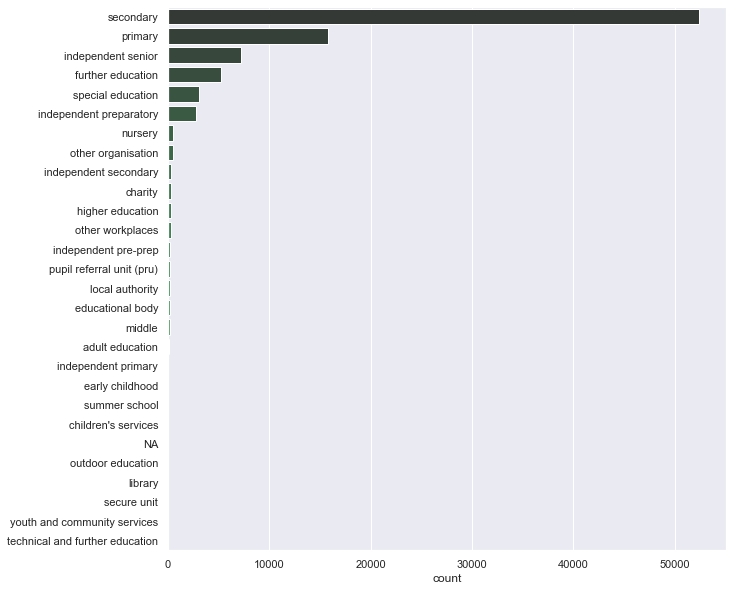

In [33]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(1,1,1)
sns.countplot(y=workplaces, ax=ax, palette="Greens_d", order=ordering);

The most frequent workplace is _'secondary'_.

The three labels are ready for training an ML model. Now let's look into features.

### Defining the Features

Remove punctuation and convert every letter to lowercase for the title as shown below. Actually, TfidfVectorizer from Scikit-Learn performs these operations so it is not implemented.

In [34]:
feature1 = list(data.title)
feature1

['Senior Assistant Director of Science',
 'Teacher of Business Studies and HSC',
 'School Business Manager',
 'EYFS Classroom Teacher',
 'Teacher',
 'Data Manager',
 'Teacher of Geography - Coventry',
 'Teacher of Science',
 'Biology Teacher',
 'Teacher of Primary',
 'Reception Class Teacher',
 'IB DP History Teacher (SL&HL)',
 'Teacher of Religious Studies (with History)',
 "Math's Teachers Required in York",
 'Teacher of English',
 'Director of Learning',
 'Music Teacher (Key Stage 3)Music Teacher (Key Stage 3)',
 'Teaching Assistant',
 'Religious Studies Teacher',
 "NQT's - Derbyshire/ Nottinghamshire",
 'Additional Support Needs Teacher',
 'Assistant Headteacher (Director of Sixth Form)',
 'Teacher of  Science',
 'Reception and Year 1 Curriculum Developer',
 'Head Teacher',
 'Year 6 Teacher',
 'Teacher of English, Deputy Head of Department',
 'Science Teacher',
 'Geography / History and Social Studies',
 'ICT & Computer Science Teacher',
 'KS1/2 Classteacher',
 'Teaching Assistant'

Remove punctuation as well as tags and convert every letter to lowercase. Tags start with "<" and end with ">". Actually TfidfVectorizer from Scikit-Learn performs these operations so it is not implemented. Only tags are removed as shown below.

In [35]:
feature2 = []

for s in data.description:
    feature2.append(re.sub('<.+?>', '', s))

In [36]:
# Combine the features (titles and descriptions)
features = []

for a,b in zip(feature1, feature2):
    features.append(a + " - " + b)

In [37]:
features[0]

'Senior Assistant Director of Science - Senior Assistant Director of Science&nbsp;\nTLR 1c (£7,623)\nOusedale School is a very successful two campus academy with an outstanding track record of results at both GCSE and A Level. We have been in the top 2% in the country for our A Level results for the past 10 years. At GCSE our results over the last year have been consistently outstanding, particularly in the core areas.&nbsp;\nWe are looking to appoint, from Easter 2018, an experienced, enthusiastic person to work closely with the Director of Science to provide clear leadership for the science department. The successful candidate will be primarily responsible for leading a team of TLR holders to deliver outstanding triple science results.&nbsp;\nWe offer:\n· An good track record at GCSE and A Level Science;\n· A supportive, friendly and innovative Science team;\n· Opportunity for continued professional development.\nThe school is committed to safeguarding and promoting the welfare of ch

In [38]:
d = {'features': [], 'positions': [], 'subjects': [], 'workplaces': []}
dataWhole = pd.DataFrame(d)
dataWhole.features = features
dataWhole.positions = positions
dataWhole.subjects = subjects
dataWhole.workplaces = workplaces
dataWhole.head(10)

,features,positions,subjects,workplaces
0,Senior Assistant Director of Science - Senior ...,deputy/assistant of department/faculty,science,secondary
1,Teacher of Business Studies and HSC - Temporar...,teacher,business studies and economics,secondary
2,School Business Manager - Position: &nbsp;&nbs...,business manager/bursar,NA,secondary
3,EYFS Classroom Teacher - We require an EYFS te...,teacher,NA,primary
4,Teacher - The Federation of Sacred Heart and S...,teacher,NA,primary
5,Data Manager - &nbsp;&nbsp;&nbsp;\nWe are seek...,data manager/analyst,NA,independent senior
6,Teacher of Geography - Coventry - &nbsp;&nbsp;...,teacher,geography,secondary
7,Teacher of Science - Teacher of Science\nMPS /...,teacher,science,secondary
8,Biology Teacher - GEMS Education is a pioneeri...,teacher,biology,secondary
9,Teacher of Primary - We are looking for enthus...,teacher,NA,primary


The features and labels are combined in a dataframe as shown above. 

Perform train, development data splitting as shown below.
__Important!!__ The variable name is called X_test or y_test but in fact the test data here is the development (hold-out cross validation data). Actually I wanted to seperate the training and test data exactly the same for each label instead of using stratified sampling to compare algorithms with a multi-task deep learning model. But since multi-task learning is not implemented, I performed stratified sampling.  

In [39]:
X_train_pos, X_test_pos, y_train_pos, y_test_pos = train_test_split(dataWhole['features'], dataWhole['positions'], test_size=0.2, stratify=dataWhole["positions"], random_state=seed)

In [40]:
X_train_subjects, X_test_subjects, y_train_subjects, y_test_subjects = train_test_split(dataWhole['features'], dataWhole['subjects'], test_size=0.2, stratify=dataWhole["subjects"], random_state=seed)

In [41]:
# Stratified sampling gives error here since there is only one instance with workplace label 'technical and further education'
# Therefore this label is taken out and inserted again later to the training set
dataWork = dataWhole[dataWhole.workplaces != 'technical and further education']
X_train_workplaces, X_test_workplaces, y_train_workplaces, y_test_workplaces = train_test_split(dataWork['features'], dataWork['workplaces'], test_size=0.2, stratify=dataWork["workplaces"] ,random_state=seed)

In [42]:
len(dataWork)

90406

In [43]:
print(X_train_pos.shape, y_train_pos.shape)
print(X_test_pos.shape, y_test_pos.shape)

(72325,) (72325,)
(18082,) (18082,)


In [44]:
print(X_train_subjects.shape, y_train_subjects.shape)
print(X_test_subjects.shape, y_test_subjects.shape)

(72325,) (72325,)
(18082,) (18082,)


In [45]:
print(X_train_workplaces.shape, y_train_workplaces.shape)
print(X_test_workplaces.shape, y_test_workplaces.shape)

(72324,) (72324,)
(18082,) (18082,)


In [46]:
X_train_workplaces

33884    Teacher of Boys PE - This is a fixed term cont...
75873    Teacher of Science - HANSON SCHOOL&nbsp;\nTEAC...
30054    Class Teacher - Job DescriptionApplications ar...
64210    Part Time Procurement and Contracts Manager - ...
14798    KS1 Teacher - Wakefield - KS1 Teacher\nWakefie...
                               ...                        
40984    Level 2 Teaching Assistant - Level 2 Teaching ...
88196    Second in Department (Science) - This is an ex...
35094    Deputy Head Pastoral - &nbsp;&nbsp;\nRequired ...
59880    Temporary Head of Drama (Full Time) - Temporar...
81648    Acting Head of Art - It is an exciting time at...
Name: features, Length: 72324, dtype: object

In [47]:
dataWhole[dataWhole.workplaces == 'technical and further education']["features"]

44936    Senior Academic Teacher - \n  Take this opport...
Name: features, dtype: object

In [48]:
X_train_workplaces = X_train_workplaces.append(dataWhole[dataWhole.workplaces == 'technical and further education']["features"])
X_train_workplaces

33884    Teacher of Boys PE - This is a fixed term cont...
75873    Teacher of Science - HANSON SCHOOL&nbsp;\nTEAC...
30054    Class Teacher - Job DescriptionApplications ar...
64210    Part Time Procurement and Contracts Manager - ...
14798    KS1 Teacher - Wakefield - KS1 Teacher\nWakefie...
                               ...                        
88196    Second in Department (Science) - This is an ex...
35094    Deputy Head Pastoral - &nbsp;&nbsp;\nRequired ...
59880    Temporary Head of Drama (Full Time) - Temporar...
81648    Acting Head of Art - It is an exciting time at...
44936    Senior Academic Teacher - \n  Take this opport...
Name: features, Length: 72325, dtype: object

In [49]:
y_train_workplaces

33884             secondary
75873             secondary
30054               primary
64210     further education
14798               primary
                ...        
40984               primary
88196             secondary
35094    independent senior
59880    independent senior
81648             secondary
Name: workplaces, Length: 72324, dtype: object

In [50]:
y_train_workplaces = y_train_workplaces.append(dataWhole[dataWhole.workplaces == 'technical and further education']["workplaces"])
y_train_workplaces

33884                          secondary
75873                          secondary
30054                            primary
64210                  further education
14798                            primary
                      ...               
88196                          secondary
35094                 independent senior
59880                 independent senior
81648                          secondary
44936    technical and further education
Name: workplaces, Length: 72325, dtype: object

In [51]:
print(X_train_workplaces.shape, y_train_workplaces.shape)
print(X_test_workplaces.shape, y_test_workplaces.shape)

(72325,) (72325,)
(18082,) (18082,)


In [52]:
TfIdf = TfidfVectorizer(analyzer='word', min_df=0.05 ,stop_words='english', lowercase=True)
# min_df, which is the minimum document frequency for deciding if a word should be included
# in the vocabulary or not

In [53]:
TfIdf.fit(X_train_pos)
X = TfIdf.transform(X_train_pos)
vocab = TfIdf.get_feature_names()
print(len(vocab))
print(X.shape)
vocab

620
(72325, 620)


['00',
 '020',
 '10',
 '100',
 '11',
 '12',
 '13',
 '15',
 '16',
 '18',
 '19',
 '20',
 '2016',
 '2017',
 '2018',
 '24',
 '30',
 '50',
 '9am',
 'abilities',
 'ability',
 'able',
 'academic',
 'academies',
 'academy',
 'accepted',
 'access',
 'accommodation',
 'achieve',
 'achieved',
 'achievement',
 'achieving',
 'act',
 'activities',
 'addition',
 'additional',
 'adults',
 'advantage',
 'age',
 'aged',
 'agency',
 'aim',
 'allowance',
 'alongside',
 'ambitious',
 'amp',
 'applicant',
 'applicants',
 'application',
 'applications',
 'apply',
 'applying',
 'appoint',
 'appointment',
 'approach',
 'appropriate',
 'april',
 'area',
 'areas',
 'arrange',
 'art',
 'aspects',
 'aspirations',
 'assessment',
 'assistant',
 'attainment',
 'attend',
 'august',
 'available',
 'background',
 'barring',
 'based',
 'basis',
 'behaviour',
 'believe',
 'benefit',
 'benefits',
 'best',
 'body',
 'build',
 'building',
 'built',
 'business',
 'campus',
 'candidate',
 'candidates',
 'care',
 'career',
 'ca

## Training Logistic Regression Models

### Logistic Regression

Below is just a quick way of training to see the results. Grid search is done later for hyperparameter selection. 
Instead of grid search, random search can be applied as well.

Tf-Idf vectorizer returns sparse matrices and it is quicker to train on sparse matrices. MaxAbsScaler can be used to scale sparse matrices. This scales each feature by its maximum absolute value.

In [39]:
scaler = MaxAbsScaler()
scaler.fit(X)
X = scaler.transform(X)

In [40]:
lr = LogisticRegression(solver='lbfgs', penalty='l2', multi_class='ovr', max_iter=1000)
lr.fit(X, y_train_pos)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='ovr', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [41]:
Xt = scaler.transform(TfIdf.transform(X_test_pos))
Xt.shape

(18082, 620)

In [42]:
y_pred_pos = lr.predict(Xt)
y_pred_pos

array(['teacher', 'other support positions', 'other support positions',
       ..., 'teacher', 'teacher', 'head of department'], dtype=object)

In [43]:
accuracy_score(y_pred_pos,y_test_pos)

0.769273310474505

In [44]:
y_test_pos

45905                                      teacher
13943                             learning support
40136    other office and administrative positions
37089                                      teacher
47181                                      teacher
                           ...                    
44883                leadership/excellence teacher
6191                                       teacher
33692                                      teacher
64987                                      teacher
50419                           head of department
Name: positions, Length: 18082, dtype: object

In [45]:
pd.Series(y_pred_pos)

0                        teacher
1        other support positions
2        other support positions
3                        teacher
4                        teacher
                  ...           
18077         head of department
18078                   lecturer
18079                    teacher
18080                    teacher
18081         head of department
Length: 18082, dtype: object

Let's do a grid search to select best min_df with other hyperparameters for each label. 

As a first model, logistic regression will be used which is a linear classifier. In order to perform multi-class classification one versus the rest scheme will be used. 

Instead of cross-valisation and grid search, a for loop could be implemented as well and the best hyperparameters can be found by testing on the hold-out validation data. First, a coarse grid search is performed and then a fine grid search following it by focusing on parameters close to the best found parameter after the coarse search. Only fine search results are shown below. 

In [39]:
#Tf-Idf Vectorizer and Logistic Regression Hyperparameters
# More hyperparameters can be searcehd this way

min_df = [0.1, 0.05] # I used min_df as 0.05 and did not look into this
# min_df of 0.05 results in 620 features
# More features may result in better accuracy but will need more training time

ngram_ranges = [(1,1), (1,2)]# I ngram_range as (1,2) and did not look into this further

C = [7, 8, 9, 10, 11, 12, 13] # L2 regularization is used

paramLR = {'TF__ngram_range': ngram_ranges, 'TF__min_df': min_df, 'LR__C': C}

kfold = StratifiedKFold(n_splits=3, shuffle=True, random_state=seed) 
# using 3 k-fold in order to reduce training time and setting random_state to seed to perform the same splitting
# for each hyperparameter combination

__Cross-validation takes a lot of time to train so I use the hold-out cross-validation set for hyperparameter tuning. Code below can be used to do grid search using pipeline.__ 

In [ ]:
TfIdf = TfidfVectorizer(analyzer='word', stop_words = 'english', lowercase=True)

scaler = MaxAbsScaler()

lr = LogisticRegression(solver='lbfgs', penalty='l2', multi_class='ovr', max_iter=1000)

pipeLR = Pipeline(steps=[('TF', TfIdf), ('SC', scaler), ('LR', lr)])

gsclfLR = GridSearchCV(estimator=pipeLR, param_grid=paramLR, cv=kfold)

start = time.time()
# !!!For cross-validation, whole dataset can be used for training and evaluation
gsclfLR.fit(dataWhole.features, dataWhole.positions)
end = time.time()

In [ ]:
print(gsclfLR.best_params_)
print('Time needed for training: {:.2f} minutes'.format((end - start)/60))

In [ ]:
print('Best score: %.2f' %gsclfLR.best_score_) 

#### Training for the label _Positions_

In [53]:
accuracyPos = []

scaler = MaxAbsScaler()

start = time.time()
        
TfIdf = TfidfVectorizer(analyzer='word', stop_words = 'english', lowercase=True, min_df=0.05, ngram_range=(1,2))

TfIdf.fit(X_train_pos)
X_train = TfIdf.transform(X_train_pos)
X_test = TfIdf.transform(X_test_pos)

scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

for pC in C:
    
    print('Training for C = ' + str(pC))

    lr = LogisticRegression(solver='lbfgs', penalty='l2', multi_class='ovr', max_iter=1000, C=pC)          
    lr.fit(X_train, y_train_pos)           
    y_pred_pos = lr.predict(X_test)
    accuracyPos.append(accuracy_score(y_test_pos, y_pred_pos))

end = time.time()           

Training for C = 7
Training for C = 8
Training for C = 9
Training for C = 10
Training for C = 11
Training for C = 12
Training for C = 13


In [54]:
print('Time needed for training: {:.2f} minutes'.format((end - start)/60))

Time needed for training: 21.43 minutes


In [55]:
accuracyPos

[0.7749142793938724,
 0.7747483685433028,
 0.7745271540758766,
 0.7750248866275854,
 0.7746377613095896,
 0.77447185045902,
 0.7746377613095896]

In [56]:
index = np.argmax(accuracyPos)
print('The regularization parameter that results in the maximum accuracy is', C[index])
print('The maximum accuracy is {:.2f}'.format(accuracyPos[index]))

The regularization parameter that results in the maximum accuracy is 10
The maximum accuracy is 0.78


Let's calculate a baseline for postions. "Teacher" is the most common position in the test dataest. If everything is predicted as 'Teacher' then accuracy would be as given below.  

In [57]:
y_test_pos.value_counts()

teacher                                      10188
head of department                            1036
teaching assistant                             965
other support positions                        659
leader/co-ordinator                            409
headteacher                                    401
technician                                     337
administrator/clerk                            318
learning support                               314
lecturer                                       281
cover supervisor                               237
deputy headteacher                             201
other office and administrative positions      189
other facilities positions                     175
assistant headteacher                          175
other pastoral/welfare positions               157
second in charge                               157
subject leadership/excellence teacher          145
trainer/assessor/verifier                      143
director of faculty/department 

In [58]:
print('Baseline Accuracy is %.2f' %(y_test_pos.value_counts()[0]/len(y_test_pos)))

Baseline Accuracy is 0.56


In [59]:
print('If a random choice would be made, accuracy would be %.2f' %(1/len(y_test_pos.unique())))

If a random choice would be made, accuracy would be 0.02


Logistic Regression definitely performs better than predicting everything as "teacher".

Let's plot the learning curve. 

In [40]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(0.01, 1.0, 50)):
    plt.figure(figsize=(10,6))
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, '-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, '-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    plt.grid("on")
    return plt

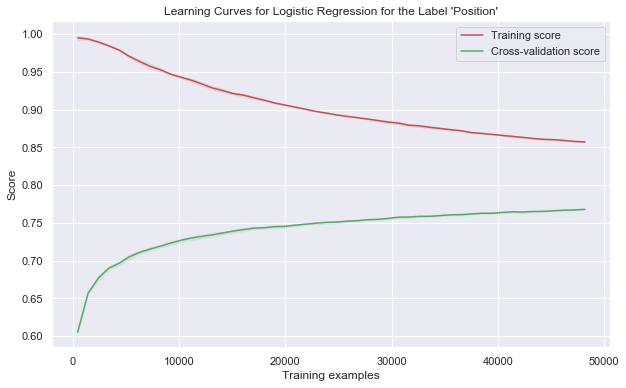

In [41]:
title = "Learning Curves for Logistic Regression for the Label 'Position'"

TfIdf = TfidfVectorizer(analyzer='word', stop_words = 'english', lowercase=True, 
                     ngram_range=(1,2), min_df=0.05)
scaler = MaxAbsScaler()
X_train = scaler.fit_transform(TfIdf.fit_transform(X_train_pos))
lr = LogisticRegression(solver='lbfgs', penalty='l2', multi_class='ovr', max_iter=1000, C=10)
#pipeLR = Pipeline(steps=[('TF', tf), ('LR', lr)])
start = time.time()
plot_learning_curve(lr, title, X_train, y_train_pos, cv=kfold)
plt.show()
end = time.time()

In [42]:
print('Time needed for plotting the learning curve: {:.2f} minutes'.format((end - start)/60))

Time needed for plotting the learning curve: 106.18 minutes


__As can be seen from the learning curve, the main problem is variance (overfitting).__

Train a logistic regression model with the tuned hyperparameters and report the results on the validations set as below. __Important!__ This is not the generalization error. But my aim here is not to report the generalization error. My aim is to find the best model using the validation data.  

In [43]:
TfIdf = TfidfVectorizer(analyzer='word', stop_words = 'english', lowercase=True, min_df=0.05, 
                     ngram_range=(1,2))
scaler = MaxAbsScaler()
lr = LogisticRegression(solver='lbfgs', penalty='l2', multi_class='ovr', max_iter=1000, C=10)

pipeLR = Pipeline(steps=[('TF', TfIdf), ('SC', scaler), ('LR', lr)])
        
#tf = tf.fit(X_train_pos)
#X_train = tf.transform(X_train_pos)
#X_test = tf.transform(X_test_pos)

pipeLR.fit(X_train_pos, y_train_pos)           
y_pred_pos = pipeLR.predict(X_test_pos)

Precision, recall and F1 values are shown below for each label. 

In [44]:
print(classification_report(y_test_pos, y_pred_pos))
print('Accuracy: %.2f' %accuracy_score(y_test_pos, y_pred_pos))

                                           precision    recall  f1-score   support

                                       NA       0.00      0.00      0.00         4
                      administrator/clerk       0.44      0.43      0.44       318
                  advanced skills teacher       0.70      0.19      0.30        36
                       advisor/consultant       0.37      0.18      0.25        38
             assistant director/principal       0.43      0.36      0.40        44
                    assistant headteacher       0.63      0.64      0.63       175
             behaviour manager/specialist       0.28      0.18      0.22        38
                  business manager/bursar       0.61      0.62      0.61        92
                          careers advisor       0.57      0.46      0.51        26
                          chaplain/priest       1.00      0.10      0.18        10
                         cover supervisor       0.85      0.82      0.84       237
   

In [45]:
y_test_pos.value_counts()

teacher                                      10188
head of department                            1036
teaching assistant                             965
other support positions                        659
leader/co-ordinator                            409
headteacher                                    401
technician                                     337
administrator/clerk                            318
learning support                               314
lecturer                                       281
cover supervisor                               237
deputy headteacher                             201
other office and administrative positions      189
assistant headteacher                          175
other facilities positions                     175
other pastoral/welfare positions               157
second in charge                               157
subject leadership/excellence teacher          145
trainer/assessor/verifier                      143
director of faculty/department 

In [46]:
y_pred_pos = pd.Series(y_pred_pos)
y_pred_pos.value_counts()

teacher                                      11168
head of department                            1068
teaching assistant                             957
other support positions                        721
headteacher                                    423
technician                                     361
administrator/clerk                            308
lecturer                                       289
learning support                               275
leader/co-ordinator                            257
cover supervisor                               227
assistant headteacher                          179
other facilities positions                     178
trainer/assessor/verifier                      158
deputy headteacher                             139
other pastoral/welfare positions               131
other office and administrative positions      119
business manager/bursar                         94
tutor                                           73
subject leadership/excellence t

Confusion matrix is shown below. This matrix can be studied for error analysis. For example the 4 "NA" values in the test set are mislabelled as "teacher" (2), "other support positions" (1) and "technician" (1). The only instance labelled "literacy worker" in the test set is mislabelled as "other support positions". These labels are very few both in the test and training set so actually the model is probably having a hard time learning about them. More instances labelled "NA", "literacy worker", etc. can tried to be gathered to improve the learning algorithm.  

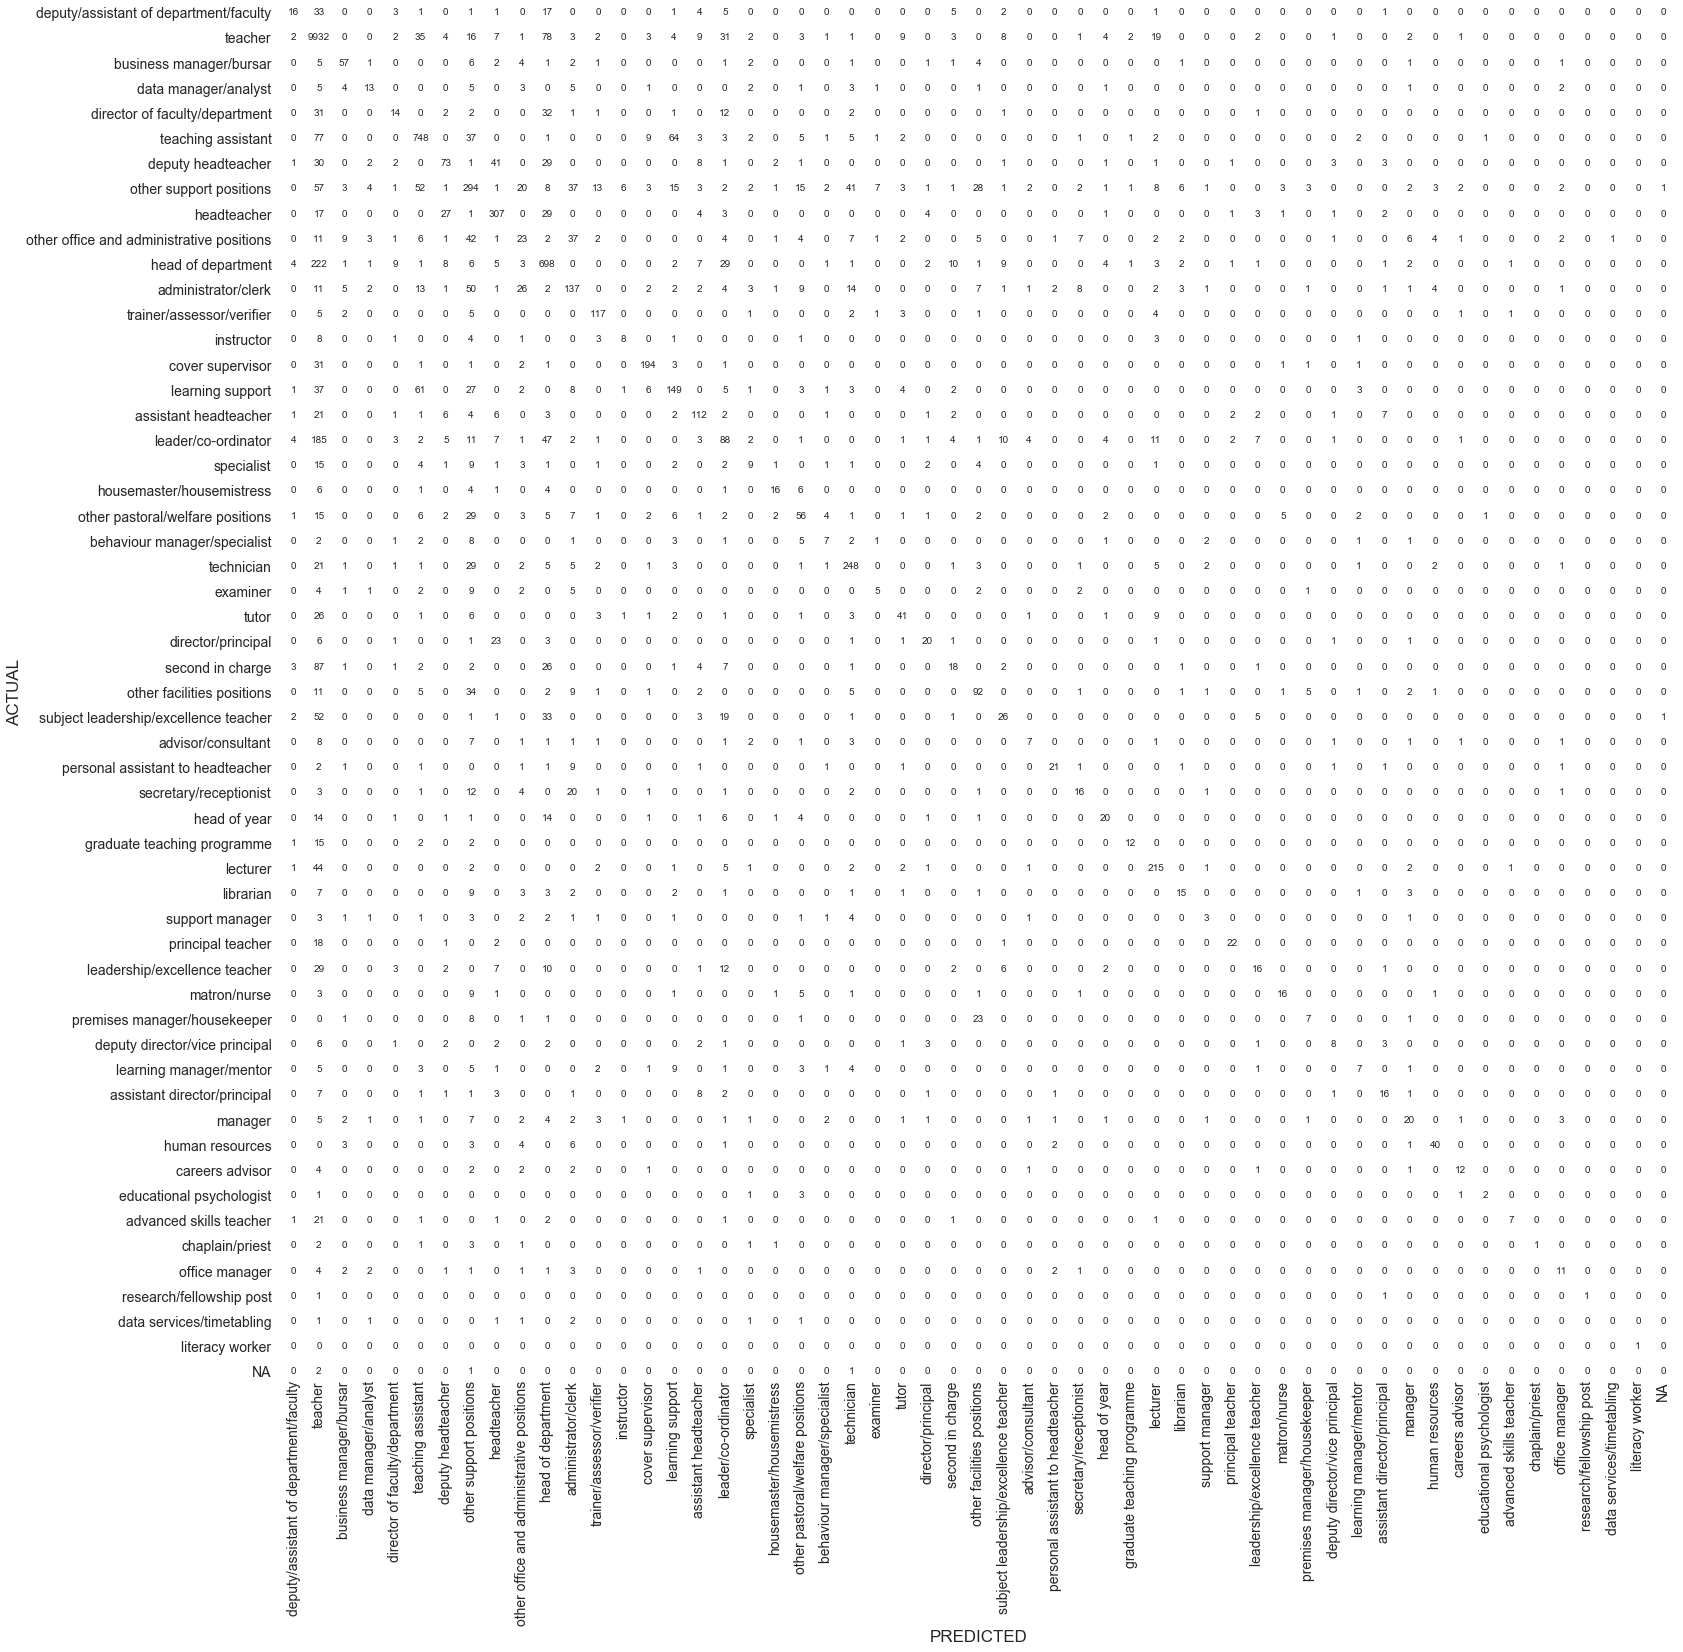

In [47]:
def draw_cm(actual, predicted, labels):
    cm = confusion_matrix(actual, predicted, labels=labels)
    plt.figure(figsize=(25,25))
    sns.heatmap(cm, annot=True,  fmt='.0f', xticklabels=labels, yticklabels=labels, 
                cmap=ListedColormap(['white']), cbar=False)
    plt.ylabel('ACTUAL', fontsize=17)
    plt.xlabel('PREDICTED', fontsize=17)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.show()
draw_cm(y_test_pos, y_pred_pos, list(dataWhole.positions.unique()))

Save the trained logistic regression model with the tf-idf vectorizer and scaler for later use. The model is trained using all data. 

In [48]:
TfIdf = TfidfVectorizer(analyzer='word', stop_words = 'english', lowercase=True, min_df=0.05, 
                     ngram_range=(1,2))
lr = LogisticRegression(solver='lbfgs', penalty='l2', multi_class='ovr', max_iter=1000, C=10)
scaler = MaxAbsScaler()
pipeLR = Pipeline(steps=[('TF', TfIdf), ('SC', scaler), ('LR', lr)])
        
#tf = tf.fit(X_train_pos)
#X_train = tf.transform(X_train_pos)
#X_test = tf.transform(X_test_pos)

pipeLR.fit(dataWhole.features, dataWhole.positions)           

Pipeline(memory=None,
         steps=[('TF',
                 TfidfVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=True, max_df=1.0, max_features=None,
                                 min_df=0.05, ngram_range=(1, 2), norm='l2',
                                 preprocessor=None, smooth_idf=True,
                                 stop_words='english', strip_accents=None,
                                 sublinear_tf=False,
                                 token_patt...)\\b\\w\\w+\\b',
                                 tokenizer=None, use_idf=True,
                                 vocabulary=None)),
                ('SC', MaxAbsScaler(copy=True)),
                ('LR',
                 LogisticRegression(C=10, class_weight=None, dual=False,
                          

In [63]:
!mkdir models

In [49]:
joblib.dump(pipeLR, 'models/LR_Model_Positions.joblib') 

['LR_Model_Positions.joblib']

In [50]:
clfPos = joblib.load('models/LR_Model_Positions.joblib') 

In [51]:
# Training error
np.mean(clfPos.predict(dataWhole.features) == dataWhole.positions)

0.8336301392591282

#### Training for the label _Subjects_

$\lambda$ parameter for regularization is tuned below. Probably decreasing min_df and increasing the number of n-grams will give better results. But training time will increase and I try only to show how I will attack this problem and my process of thinking instead of doing everything.   

In [60]:
accuracySubjects = []
C = [12, 13, 14, 15, 16, 17, 18]

start = time.time()
        
TfIdf = TfidfVectorizer(analyzer='word', stop_words = 'english', lowercase=True, min_df=0.05, ngram_range=(1,2))

TfIdf.fit(X_train_subjects)
X_train = TfIdf.transform(X_train_subjects)
X_test = TfIdf.transform(X_test_subjects)

scaler = MaxAbsScaler()

scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

for pC in C:
    
    print('Training for C = ' + str(pC))

    lr = LogisticRegression(solver='lbfgs', penalty='l2', multi_class='ovr', max_iter=1000, C=pC)          
    lr.fit(X_train, y_train_subjects)           
    y_pred_subjects = lr.predict(X_test)
    accuracySubjects.append(accuracy_score(y_test_subjects, y_pred_subjects))

end = time.time() 

Training for C = 12
Training for C = 13
Training for C = 14
Training for C = 15
Training for C = 16
Training for C = 17
Training for C = 18


In [61]:
print('Time needed for training: {:.2f} minutes'.format((end - start)/60))

Time needed for training: 25.15 minutes


In [62]:
accuracySubjects

[0.6777458245769273,
 0.6778564318106404,
 0.6775799137263577,
 0.6775799137263577,
 0.6776352173432142,
 0.6780223426612101,
 0.6778011281937839]

In [63]:
index = np.argmax(accuracySubjects)
print('The regularization parameter that results in the maximum accuracy is', C[index])
print('The maximum accuracy is {:.2f}'.format(accuracySubjects[index]))

The regularization parameter that results in the maximum accuracy is 17
The maximum accuracy is 0.68


In [64]:
y_test_subjects.value_counts()

NA                           6572
mathematics                  1494
english                      1369
science                      1225
modern languages              684
                             ... 
architecture and planning       2
christian studies               1
jewish studies                  1
environmental studies           1
logistics and transport         1
Name: subjects, Length: 62, dtype: int64

In [65]:
print('If a random choice would be made, accuracy would be %.2f' %(1/len(y_test_subjects.unique())))

If a random choice would be made, accuracy would be 0.02


In [66]:
print('Baseline Accuracy is %.2f' %(y_test_subjects.value_counts()[0]/len(y_test_subjects)))

Baseline Accuracy is 0.36


Logistic Regression definitely performs better than predicting everything as "NA" meaning predicting nothing.

/Users/coskudeniz/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:657: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of members in any class cannot be less than n_splits=3.
  % (min_groups, self.n_splits)), Warning)


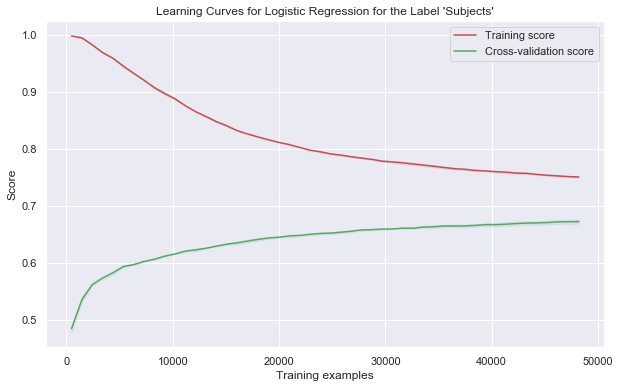

In [52]:
title = "Learning Curves for Logistic Regression for the Label 'Subjects'"

TfIdf = TfidfVectorizer(analyzer='word', stop_words = 'english', lowercase=True, 
                     ngram_range=(1,2), min_df=0.05)
scaler = MaxAbsScaler()
X_train = scaler.fit_transform(TfIdf.fit_transform(X_train_subjects))
lr = LogisticRegression(solver='lbfgs', penalty='l2', multi_class='ovr', max_iter=1000, C=17)
#pipeLR = Pipeline(steps=[('TF', tf), ('LR', lr)])
start = time.time()
plot_learning_curve(lr, title, X_train, y_train_subjects, cv=kfold)
plt.show()
end = time.time()

In [53]:
print('Time needed for plotting the learning curve: {:.2f} minutes'.format((end - start)/60))

Time needed for plotting the learning curve: 139.90 minutes


__As can be seen from the learning curve, the main problem is variance (overfitting).__

Let's train the model that has the best accuracy measured on the validation set and report the results on the validation set. __Important!__ This is again not the generalization error. 

In [54]:
TfIdf = TfidfVectorizer(analyzer='word', stop_words = 'english', lowercase=True, min_df=0.05, ngram_range=(1,2))
scaler = MaxAbsScaler()
lr = LogisticRegression(solver='lbfgs', penalty='l2', multi_class='ovr', max_iter=1000, C=17)

pipeLR = Pipeline(steps=[('TF', TfIdf), ('SC', scaler), ('LR', lr)])

pipeLR.fit(X_train_subjects, y_train_subjects)           
y_pred_subjects = pipeLR.predict(X_test_subjects)

Precision, recall and F1 values are shown below for each label. 

In [55]:
print(classification_report(y_test_subjects, y_pred_subjects))
print('Accuracy: %.2f' %accuracy_score(y_test_subjects, y_pred_subjects))

/Users/coskudeniz/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


                                               precision    recall  f1-score   support

                                           NA       0.69      0.91      0.78      6572
aboriginal and torres strait islander studies       0.00      0.00      0.00        11
                       accounting and finance       0.21      0.05      0.09        56
                            aerospace studies       1.00      0.43      0.60         7
                    agriculture/rural science       0.40      0.33      0.36        12
                               animal studies       0.75      0.20      0.32        15
                    architecture and planning       0.00      0.00      0.00         2
                               art and design       0.81      0.75      0.78       348
                                      biology       0.23      0.08      0.12       217
               business studies and economics       0.79      0.75      0.77       379
                                      care

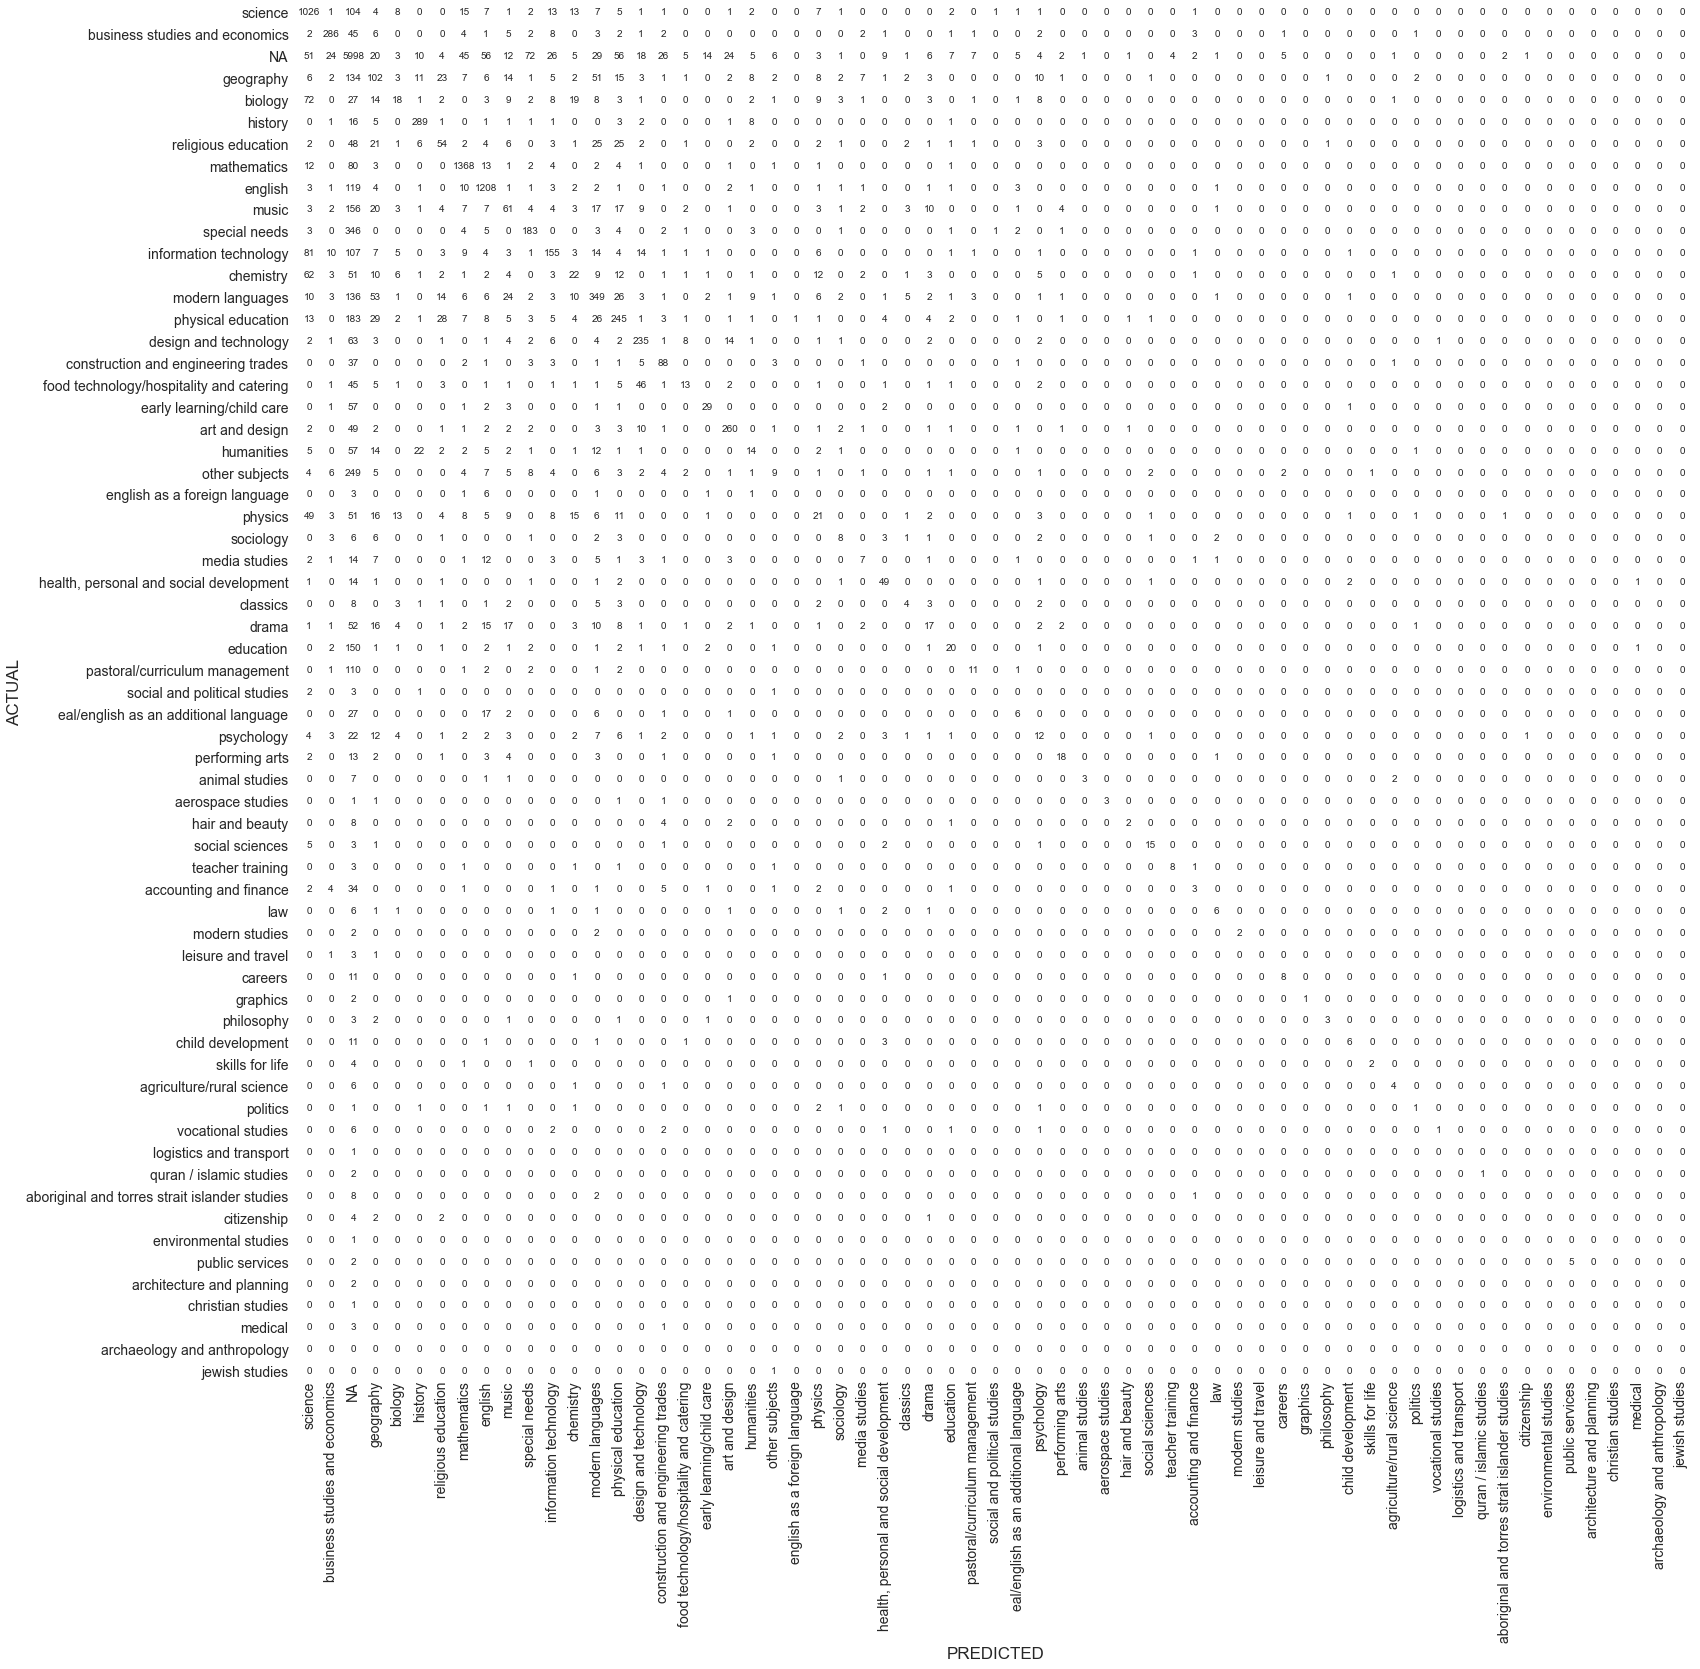

In [56]:
draw_cm(y_test_subjects, y_pred_subjects, list(dataWhole.subjects.unique()))

Again mostly instances with labels that have small numbers in the dataset are mislabelled. Also some labelled instances exist in the training data but not in the test data like 'archaeology and anthropology'.

In [57]:
'archaeology and anthropology' in y_train_subjects.value_counts().index

True

In [58]:
'archaeology and anthropology' in y_test_subjects.value_counts().index

False

Save the model trained on the whole data. 

In [59]:
TfIdf = TfidfVectorizer(analyzer='word', stop_words = 'english', lowercase=True, min_df=0.05, ngram_range=(1,2))
scaler = MaxAbsScaler()
lr = LogisticRegression(solver='lbfgs', penalty='l2', multi_class='ovr', max_iter=1000, C=17)

pipeLR = Pipeline(steps=[('TF', TfIdf), ('SC', scaler), ('LR', lr)])
        
#tf = tf.fit(X_train_pos)
#X_train = tf.transform(X_train_pos)
#X_test = tf.transform(X_test_pos)

pipeLR.fit(dataWhole.features, dataWhole.subjects)  

Pipeline(memory=None,
         steps=[('TF',
                 TfidfVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=True, max_df=1.0, max_features=None,
                                 min_df=0.05, ngram_range=(1, 2), norm='l2',
                                 preprocessor=None, smooth_idf=True,
                                 stop_words='english', strip_accents=None,
                                 sublinear_tf=False,
                                 token_patt...)\\b\\w\\w+\\b',
                                 tokenizer=None, use_idf=True,
                                 vocabulary=None)),
                ('SC', MaxAbsScaler(copy=True)),
                ('LR',
                 LogisticRegression(C=17, class_weight=None, dual=False,
                          

In [60]:
joblib.dump(pipeLR, 'models/LR_Model_Subjects.joblib') 

['LR_Model_Subjects.joblib']

In [61]:
clfSub = joblib.load('models/LR_Model_Subjects.joblib') 
# Training error
np.mean(clfSub.predict(dataWhole.features) == dataWhole.subjects)

0.7278086873804019

#### Training for the label _Workplaces_

In [67]:
accuracyWork = []
C = [22, 23, 24, 25, 26, 27, 28]

start = time.time()
        
TfIdf = TfidfVectorizer(analyzer='word', stop_words = 'english', lowercase=True, min_df=0.05, ngram_range=(1,2))

TfIdf.fit(X_train_workplaces)
X_train = TfIdf.transform(X_train_workplaces)
X_test = TfIdf.transform(X_test_workplaces)

scaler = MaxAbsScaler()

scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

for pC in C:
    
    print('Training for C = ' + str(pC))

    lr = LogisticRegression(solver='lbfgs', penalty='l2', multi_class='ovr', max_iter=1000, C=pC)          
    lr.fit(X_train, y_train_workplaces)           
    y_pred_workplaces = lr.predict(X_test)
    accuracyWork.append(accuracy_score(y_test_workplaces, y_pred_workplaces))

end = time.time() 

Training for C = 22
Training for C = 23
Training for C = 24
Training for C = 25
Training for C = 26
Training for C = 27
Training for C = 28


In [68]:
print('Time needed for training: {:.2f} minutes'.format((end - start)/60))

Time needed for training: 11.80 minutes


In [69]:
accuracyWork

[0.8594735095675257,
 0.8595288131843822,
 0.8595841168012388,
 0.8593629023338126,
 0.8592522951000996,
 0.859196991483243,
 0.859196991483243]

In [70]:
index = np.argmax(accuracyWork)
print('The regularization parameter that results in the maximum accuracy is', C[index])
print('The maximum accuracy is {:.2f}'.format(accuracyWork[index]))

The regularization parameter that results in the maximum accuracy is 24
The maximum accuracy is 0.86


In [71]:
print('Baseline Accuracy is %.2f' %(y_test_workplaces.value_counts()[0]/len(y_test_workplaces)))

Baseline Accuracy is 0.58


In [72]:
print('If a random choice would be made, accuracy would be %.2f' %(1/len(y_test_workplaces.unique())))

If a random choice would be made, accuracy would be 0.04


In [73]:
y_test_workplaces.value_counts()

secondary                       10482
primary                          3169
independent senior               1443
further education                1056
special education                 623
independent preparatory           568
nursery                           106
other organisation                 95
independent secondary              74
charity                            62
higher education                   57
other workplaces                   57
pupil referral unit (pru)          47
independent pre-prep               47
local authority                    44
educational body                   42
middle                             39
adult education                    34
independent primary                10
early childhood                     7
summer school                       5
NA                                  4
children's services                 4
library                             2
secure unit                         2
outdoor education                   2
youth and co

Logistic regression model trained performs better than prediciting everything as 'secondary' in terms of accuracy. 

/Users/coskudeniz/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:657: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=3.
  % (min_groups, self.n_splits)), Warning)


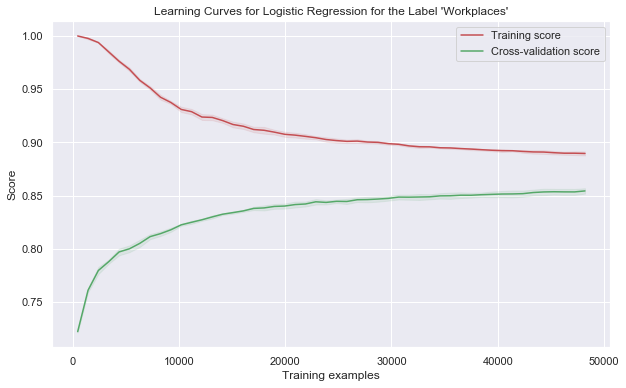

In [62]:
title = "Learning Curves for Logistic Regression for the Label 'Workplaces'"

TfIdf = TfidfVectorizer(analyzer='word', stop_words = 'english', lowercase=True, 
                     ngram_range=(1,2), min_df=0.05)
scaler = MaxAbsScaler()
X_train = scaler.fit_transform(TfIdf.fit_transform(X_train_workplaces))
lr = LogisticRegression(solver='lbfgs', penalty='l2', multi_class='ovr', max_iter=1000, C=24)
#pipeLR = Pipeline(steps=[('TF', tf), ('LR', lr)])
start = time.time()
plot_learning_curve(lr, title, X_train, y_train_workplaces, cv=kfold)
plt.show()
end = time.time()

In [63]:
print('Time needed for plotting the learning curve: {:.2f} minutes'.format((end - start)/60))

Time needed for plotting the learning curve: 58.60 minutes


__Again the main problem is variance (overfitting).__

In [64]:
TfIdf = TfidfVectorizer(analyzer='word', stop_words = 'english', lowercase=True, min_df=0.05, ngram_range=(1,2))
scaler = MaxAbsScaler()
lr = LogisticRegression(solver='lbfgs', penalty='l2', multi_class='ovr', max_iter=1000, C=24)

pipeLR = Pipeline(steps=[('TF', TfIdf), ('SC', scaler), ('LR', lr)])

pipeLR.fit(X_train_workplaces, y_train_workplaces)           
y_pred_workplaces = pipeLR.predict(X_test_workplaces)

In [65]:
print(classification_report(y_test_workplaces, y_pred_workplaces))
print('Accuracy: %.2f' %accuracy_score(y_test_workplaces, y_pred_workplaces))

/Users/coskudeniz/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


                              precision    recall  f1-score   support

                          NA       0.00      0.00      0.00         4
             adult education       0.71      0.59      0.65        34
                     charity       0.89      0.77      0.83        62
         children's services       0.00      0.00      0.00         4
             early childhood       1.00      0.71      0.83         7
            educational body       0.50      0.24      0.32        42
           further education       0.85      0.85      0.85      1056
            higher education       0.55      0.32      0.40        57
        independent pre-prep       0.54      0.32      0.40        47
     independent preparatory       0.72      0.55      0.62       568
         independent primary       0.67      0.20      0.31        10
       independent secondary       0.76      0.57      0.65        74
          independent senior       0.72      0.68      0.70      1443
                   

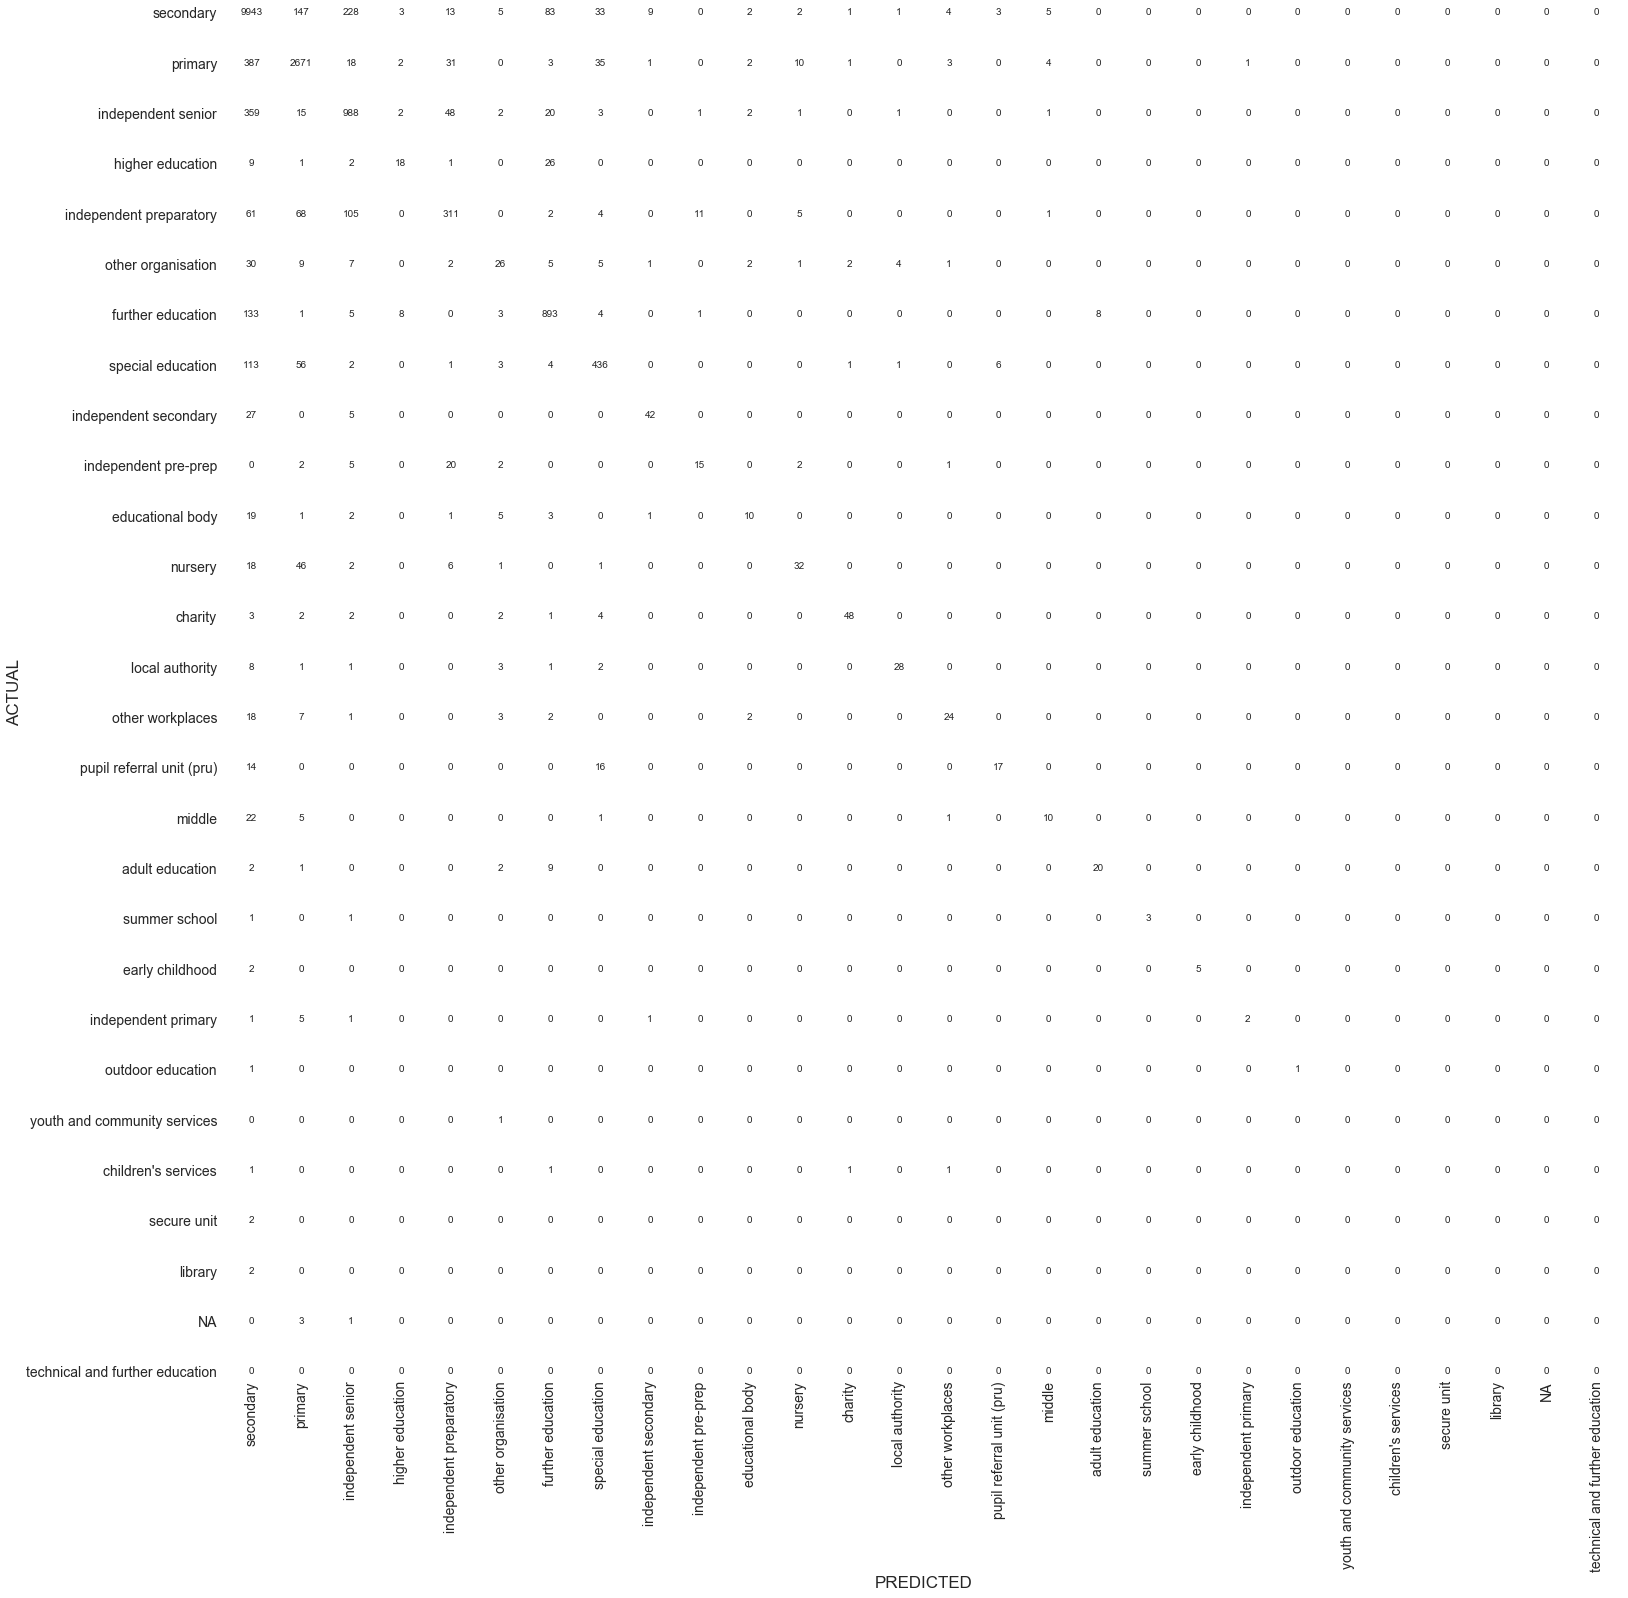

In [66]:
draw_cm(y_test_workplaces, y_pred_workplaces, list(dataWhole.workplaces.unique()))

Save the model trained using the whole dataset. 

In [67]:
TfIdf = TfidfVectorizer(analyzer='word', stop_words = 'english', lowercase=True, min_df=0.05, ngram_range=(1,2))
scaler = MaxAbsScaler()
lr = LogisticRegression(solver='lbfgs', penalty='l2', multi_class='ovr', max_iter=1000, C=24)

pipeLR = Pipeline(steps=[('TF', TfIdf), ('SC', scaler), ('LR', lr)])
        
#tf = tf.fit(X_train_pos)
#X_train = tf.transform(X_train_pos)
#X_test = tf.transform(X_test_pos)

pipeLR.fit(dataWhole.features, dataWhole.workplaces) 

Pipeline(memory=None,
         steps=[('TF',
                 TfidfVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=True, max_df=1.0, max_features=None,
                                 min_df=0.05, ngram_range=(1, 2), norm='l2',
                                 preprocessor=None, smooth_idf=True,
                                 stop_words='english', strip_accents=None,
                                 sublinear_tf=False,
                                 token_patt...)\\b\\w\\w+\\b',
                                 tokenizer=None, use_idf=True,
                                 vocabulary=None)),
                ('SC', MaxAbsScaler(copy=True)),
                ('LR',
                 LogisticRegression(C=24, class_weight=None, dual=False,
                          

In [68]:
joblib.dump(pipeLR, 'models/LR_Model_Workplaces.joblib') 

['LR_Model_Workplaces.joblib']

In [69]:
clfWork = joblib.load('models/LR_Model_Workplaces.joblib') 
# Training error
np.mean(clfWork.predict(dataWhole.features) == dataWhole.workplaces)

0.8809826672713396

Three models are saved and these can be used for prediction. As can be seen from the learning curves, gathering more training data will definitely help. Especially gathering data for the instances with not much number of labels in the dataset. Increasing regularization and trying L1-norm can be other paths to follow. Decreasing the number of features may be another possible way to proceed. 

Logistic Regression can only seperate classes that are linearly seperable. However, compared to baselines that do not use ML models, logistic regression outperfoms them in terms of accuracy. 

## Training Naive Bayes Models

Let's try Naive Bayes which works well in practive for text data even though it is a simple model that assumes independence between features given the labels. This independence assumption is definitely not true for this dataset but in practice Naive Bayes works well for text data and it is worth a try.

### Multinomial Naive Bayes

#### Training for the label _Position_

In [71]:
vectorizer = CountVectorizer(analyzer='word', stop_words = 'english', lowercase=True, ngram_range=(1,2))

vectorizer.fit(X_train_pos)
X_train = vectorizer.transform(X_train_pos)

clf = MultinomialNB()
clf.fit(X_train, y_train_pos)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [73]:
ypred = clf.predict(vectorizer.transform(X_test_pos))

In [74]:
accuracy_score(y_test_pos, ypred)

0.6664638867381927

#### Training for the label _Subjects_

In [75]:
vectorizer = CountVectorizer(analyzer='word', stop_words = 'english', lowercase=True, ngram_range=(1,2))

vectorizer.fit(X_train_subjects)
X_train = vectorizer.transform(X_train_subjects)

clf = MultinomialNB()
clf.fit(X_train, y_train_subjects)

ypred = clf.predict(vectorizer.transform(X_test_subjects))
accuracy_score(y_test_subjects, ypred)

0.5263245216237142

#### Training for the label _Workplaces_

In [76]:
vectorizer = CountVectorizer(analyzer='word', stop_words = 'english', lowercase=True, ngram_range=(1,2))

vectorizer.fit(X_train_workplaces)
X_train = vectorizer.transform(X_train_workplaces)

clf = MultinomialNB()
clf.fit(X_train, y_train_workplaces)

ypred = clf.predict(vectorizer.transform(X_test_workplaces))
accuracy_score(y_test_workplaces, ypred)

0.8344762747483685

### Bernoulli Naive Bayes - Bag of Words

#### Training for the label _Position_

In [77]:
vectorizer = CountVectorizer(analyzer='word', stop_words = 'english', lowercase=True, ngram_range=(1,2), 
                             binary=True)
vectorizer.fit(X_train_pos)
X_train = vectorizer.transform(X_train_pos)

clf = BernoulliNB()
clf.fit(X_train, y_train_pos)

ypred = clf.predict(vectorizer.transform(X_test_pos))
accuracy_score(y_test_pos, ypred)

0.589315341223316

#### Training for the label _Subjects_

In [78]:
vectorizer = CountVectorizer(analyzer='word', stop_words = 'english', lowercase=True, ngram_range=(1,2), 
                             binary=True)
vectorizer.fit(X_train_subjects)
X_train = vectorizer.transform(X_train_subjects)

clf = BernoulliNB()
clf.fit(X_train, y_train_subjects)

ypred = clf.predict(vectorizer.transform(X_test_subjects))
accuracy_score(y_test_subjects, ypred)

0.43236367658444863

#### Training for the label _Workplaces_

In [79]:
vectorizer = CountVectorizer(analyzer='word', stop_words = 'english', lowercase=True, ngram_range=(1,2), 
                             binary=True)
vectorizer.fit(X_train_workplaces)
X_train = vectorizer.transform(X_train_workplaces)

clf = BernoulliNB()
clf.fit(X_train, y_train_workplaces)

ypred = clf.predict(vectorizer.transform(X_test_workplaces))
accuracy_score(y_test_workplaces, ypred)

0.7801128193783874

Naive Bayes using bag-of-words performs worse than modelling the words with a multinomial distribution. Both cases perform worse than logisitc regression in terms of measured accuracy on the validation set. For multinomal Naive Bayes, sometimes tf-idf values can be used instead of word counts but I did not look into that. 

## Training Deep Learning Models

In [80]:
def build_model(layers, dropOutRate=0.5, L2=0.1, learningRate=0.001):
    
    index = 0
    
    model = keras.Sequential()
    
    while index < len(layers):
        if index == 0:
            model.add(keras.layers.Dense(layers[index+1], input_dim=layers[index], activation='relu',
                                         kernel_regularizer=keras.regularizers.l2(l=L2)))
            model.add(keras.layers.Dropout(dropOutRate))
            index += 2 
        elif index == len(layers)-1:
            model.add(keras.layers.Dense(layers[index], activation='softmax', 
                                         kernel_regularizer=keras.regularizers.l2(l=L2)))
            index += 1
        else:
            model.add(keras.layers.Dense(layers[index], activation='relu', 
                                         kernel_regularizer=keras.regularizers.l2(l=L2)))
            model.add(keras.layers.Dropout(dropOutRate))
            index += 1
    
    model.compile(loss='categorical_crossentropy', 
                  optimizer=keras.optimizers.Adam(learning_rate=learningRate, beta_1=0.9, beta_2=0.999),
                  metrics=['acc'])
    
    return model

#### Training for the label _Position_

In [83]:
lb = LabelBinarizer()
lb.fit(dataWhole.positions)
y_train = lb.transform(y_train_pos)
y_train.shape

(72325, 55)

In [84]:
TfIdf = TfidfVectorizer(analyzer='word', stop_words = 'english', lowercase=True, min_df=0.05, ngram_range=(1,2))

TfIdf.fit(X_train_pos)
X_train = TfIdf.transform(X_train_pos)

X_train = X_train.toarray()

scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)

print(X_train.shape)

X_val = scaler.transform(TfIdf.transform(X_test_pos).toarray())
print(X_val.shape)

y_val = lb.transform(y_test_pos)
print(y_val.shape)

valData = (X_val, y_val)

(72325, 779)
(18082, 779)
(18082, 55)


In [85]:
layers = [X_train.shape[1], 120, y_train.shape[1]]
model1 = build_model(layers)

history1 = model1.fit(X_train, y_train, epochs=50, batch_size=64, validation_data=valData, verbose=1, shuffle=True)

Train on 72325 samples, validate on 18082 samples
Epoch 1/50
72325/72325 [==============================] - 2s 28us/sample - loss: 3.4431 - acc: 0.5751 - val_loss: 2.0449 - val_acc: 0.5877
Epoch 2/50
72325/72325 [==============================] - 2s 23us/sample - loss: 2.0491 - acc: 0.5854 - val_loss: 2.0162 - val_acc: 0.5864
Epoch 3/50
72325/72325 [==============================] - 2s 23us/sample - loss: 2.0351 - acc: 0.5858 - val_loss: 2.0054 - val_acc: 0.5844
Epoch 4/50
72325/72325 [==============================] - 2s 23us/sample - loss: 2.0292 - acc: 0.5852 - val_loss: 2.0053 - val_acc: 0.5837
Epoch 5/50
72325/72325 [==============================] - 2s 23us/sample - loss: 2.0237 - acc: 0.5862 - val_loss: 1.9974 - val_acc: 0.5845
Epoch 6/50
72325/72325 [==============================] - 2s 28us/sample - loss: 2.0211 - acc: 0.5859 - val_loss: 2.0065 - val_acc: 0.5867
Epoch 7/50
72325/72325 [==============================] - 2s 23us/sample - loss: 2.0192 - acc: 0.5855 - val_loss: 2.

In [86]:
predicted1 = model1.predict(X_val)

In [87]:
predicted1[0]

array([1.1934930e-04, 8.6332560e-03, 1.1980992e-03, 1.0870595e-03,
       1.3484801e-03, 4.6845903e-03, 1.1244838e-03, 2.7020769e-03,
       7.0200459e-04, 3.1968846e-04, 7.8146327e-03, 1.3957254e-03,
       2.3272895e-04, 9.6228672e-04, 5.7628639e-03, 2.3715589e-03,
       2.9658417e-03, 1.7659497e-03, 2.2772601e-04, 9.7152020e-04,
       9.0483122e-04, 2.6141355e-02, 1.8363006e-03, 9.7079221e-03,
       1.0968022e-03, 1.6548787e-03, 1.0366751e-03, 1.2759235e-02,
       2.7958588e-03, 1.3308208e-03, 8.1093395e-03, 8.7859696e-03,
       1.4201346e-03, 3.7356785e-05, 1.6842213e-03, 1.1742458e-03,
       9.1541681e-04, 4.0020384e-03, 5.2179298e-03, 5.3732963e-03,
       1.6662054e-02, 1.3237539e-03, 1.2655156e-03, 1.1895495e-03,
       7.4335505e-05, 4.6477509e-03, 1.8164673e-03, 1.5445243e-03,
       4.9100774e-03, 7.6783169e-04, 7.8101861e-01, 2.5056362e-02,
       9.8054251e-03, 4.2735334e-03, 3.2697830e-03], dtype=float32)

In [88]:
predictedLabels1 = lb.inverse_transform(predicted1)
predictedLabels1

array(['teacher', 'teacher', 'teacher', ..., 'teacher', 'teacher',
       'teacher'], dtype='<U41')

In [89]:
print('Validation Accuracy: %.2f' %np.mean(predictedLabels1 == y_test_pos))

Validation Accuracy: 0.59


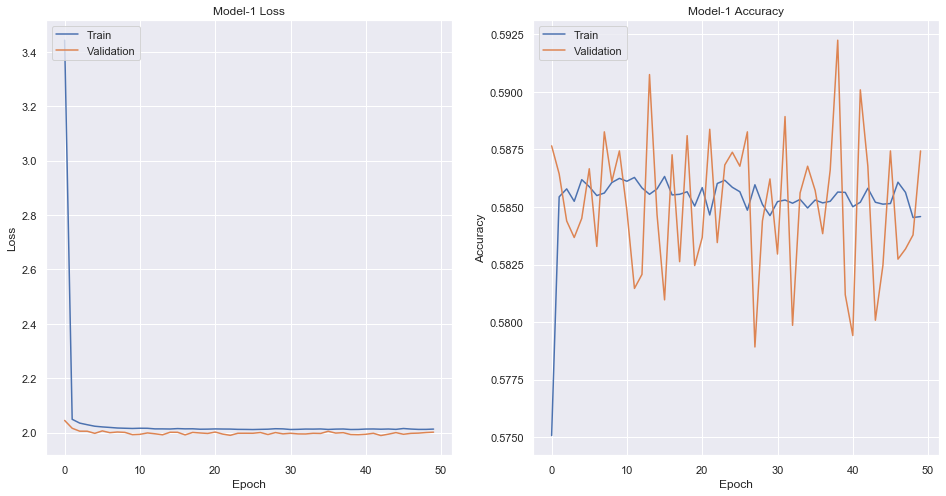

In [95]:
fig = plt.figure(figsize=(16,8))

# Plot training & validation loss values
plt.subplot(1,2,1)
plt.plot(history1.history['loss'])
plt.plot(history1.history['val_loss'])
plt.title('Model-1 Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation accuracy values
plt.subplot(1,2,2)
plt.plot(history1.history['acc'])
plt.plot(history1.history['val_acc'])
plt.title('Model-1 Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

Not a good result at all compared to logistic regression. Let's try decreasing regularizarion since bias (underfitting) is the problem here. This can be seen when training and validation losses are compared. Let's decrease both drop-out rate and L2 regularization. 

In [91]:
layers = [X_train.shape[1], 120, y_train.shape[1]]
model2 = build_model(layers, 0.1, 0.01)

history2 = model2.fit(X_train, y_train, epochs=50, batch_size=64, validation_data=valData, verbose=1, shuffle=True)

Train on 72325 samples, validate on 18082 samples
Epoch 1/50
72325/72325 [==============================] - 3s 44us/sample - loss: 2.0047 - acc: 0.6970 - val_loss: 1.4406 - val_acc: 0.7275
Epoch 2/50
72325/72325 [==============================] - 2s 24us/sample - loss: 1.4331 - acc: 0.7264 - val_loss: 1.3926 - val_acc: 0.7325
Epoch 3/50
72325/72325 [==============================] - 2s 23us/sample - loss: 1.4107 - acc: 0.7257 - val_loss: 1.3823 - val_acc: 0.7283
Epoch 4/50
72325/72325 [==============================] - 2s 23us/sample - loss: 1.4024 - acc: 0.7255 - val_loss: 1.3792 - val_acc: 0.7303
Epoch 5/50
72325/72325 [==============================] - 2s 23us/sample - loss: 1.3969 - acc: 0.7259 - val_loss: 1.3742 - val_acc: 0.7343
Epoch 6/50
72325/72325 [==============================] - 2s 28us/sample - loss: 1.3954 - acc: 0.7249 - val_loss: 1.3731 - val_acc: 0.7277
Epoch 7/50
72325/72325 [==============================] - 2s 22us/sample - loss: 1.3937 - acc: 0.7245 - val_loss: 1.

Compares much better in terms of loss to the previous network. Let's see how well does it on the hold-out validation data. 

In [93]:
predicted2 = model2.predict(X_val)
predictedLabels2 = lb.inverse_transform(predicted2)
print('Validation Accuracy: %.2f' %np.mean(predictedLabels2 == y_test_pos))

Validation Accuracy: 0.73


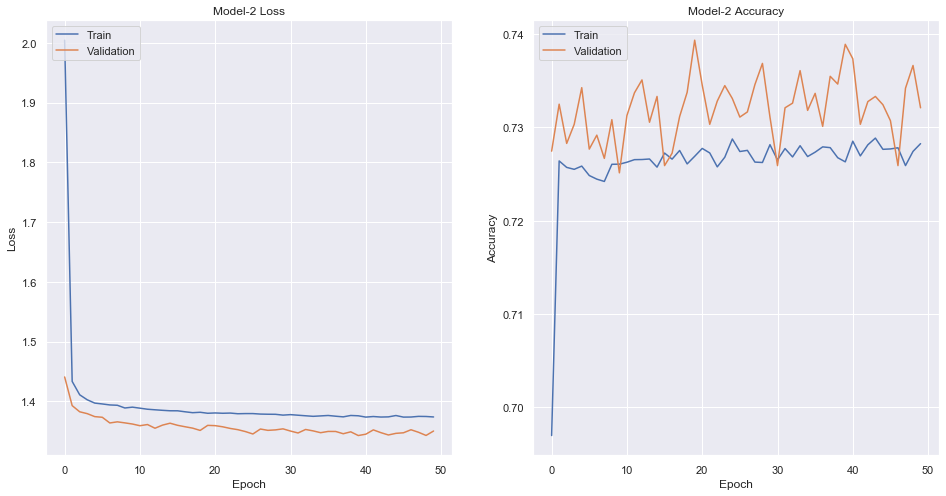

In [94]:
fig = plt.figure(figsize=(16,8))

# Plot training & validation loss values
plt.subplot(1,2,1)
plt.plot(history2.history['loss'])
plt.plot(history2.history['val_loss'])
plt.title('Model-2 Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation accuracy values
plt.subplot(1,2,2)
plt.plot(history2.history['acc'])
plt.plot(history2.history['val_acc'])
plt.title('Model-2 Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

Much better. Still the problem is underfitting (bias). Let's continue decreasing regularization and increasing layer numbers and hidden units. Also loss keeps decreasing as seen in the plot above. Maybe increasing learning rate may help the network learn faster. Also increasing the number of epochs can help. 

In [96]:
layers = [X_train.shape[1], 120, y_train.shape[1]]
model3 = build_model(layers, 0, 0)

history3 = model3.fit(X_train, y_train, epochs=50, batch_size=64, validation_data=valData, verbose=1, shuffle=True)

Train on 72325 samples, validate on 18082 samples
Epoch 1/50
72325/72325 [==============================] - 2s 24us/sample - loss: 1.1060 - acc: 0.7223 - val_loss: 0.8374 - val_acc: 0.7735
Epoch 2/50
72325/72325 [==============================] - 2s 21us/sample - loss: 0.6984 - acc: 0.8078 - val_loss: 0.7970 - val_acc: 0.7852
Epoch 3/50
72325/72325 [==============================] - 2s 21us/sample - loss: 0.5759 - acc: 0.8381 - val_loss: 0.8050 - val_acc: 0.7889
Epoch 4/50
72325/72325 [==============================] - 2s 21us/sample - loss: 0.4882 - acc: 0.8602 - val_loss: 0.8251 - val_acc: 0.7924
Epoch 5/50
72325/72325 [==============================] - 2s 21us/sample - loss: 0.4160 - acc: 0.8785 - val_loss: 0.8725 - val_acc: 0.7936
Epoch 6/50
72325/72325 [==============================] - 2s 21us/sample - loss: 0.3586 - acc: 0.8940 - val_loss: 0.9142 - val_acc: 0.7944
Epoch 7/50
72325/72325 [==============================] - 2s 28us/sample - loss: 0.3107 - acc: 0.9085 - val_loss: 0.

With no regularizations as shown above, the problem is variance (overfitting) this time. 

In [97]:
predicted3 = model3.predict(X_val)
predictedLabels3 = lb.inverse_transform(predicted3)
print('Validation Accuracy: %.2f' %np.mean(predictedLabels3 == y_test_pos))

Validation Accuracy: 0.78


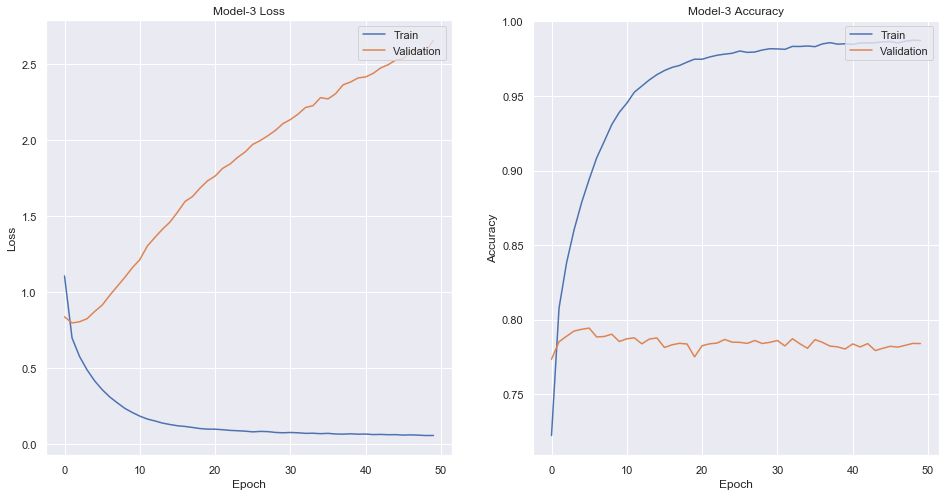

In [98]:
fig = plt.figure(figsize=(16,8))

# Plot training & validation loss values
plt.subplot(1,2,1)
plt.plot(history3.history['loss'])
plt.plot(history3.history['val_loss'])
plt.title('Model-3 Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')

# Plot training & validation accuracy values
plt.subplot(1,2,2)
plt.plot(history3.history['acc'])
plt.plot(history3.history['val_acc'])
plt.title('Model-3 Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

Performs the same in terms of accuracy with the logistic regression model. 

In [99]:
layers = [X_train.shape[1], 120, y_train.shape[1]]
model4 = build_model(layers, 0.5, 0)

history4 = model4.fit(X_train, y_train, epochs=50, batch_size=64, validation_data=valData, verbose=1, shuffle=True)

Train on 72325 samples, validate on 18082 samples
Epoch 1/50
72325/72325 [==============================] - 2s 25us/sample - loss: 1.3951 - acc: 0.6662 - val_loss: 0.9224 - val_acc: 0.7520
Epoch 2/50
72325/72325 [==============================] - 2s 21us/sample - loss: 0.9718 - acc: 0.7426 - val_loss: 0.8345 - val_acc: 0.7701
Epoch 3/50
72325/72325 [==============================] - 2s 21us/sample - loss: 0.8887 - acc: 0.7581 - val_loss: 0.8075 - val_acc: 0.7776
Epoch 4/50
72325/72325 [==============================] - 2s 23us/sample - loss: 0.8375 - acc: 0.7695 - val_loss: 0.8057 - val_acc: 0.7794
Epoch 5/50
72325/72325 [==============================] - 2s 23us/sample - loss: 0.8009 - acc: 0.7770 - val_loss: 0.7944 - val_acc: 0.7848
Epoch 6/50
72325/72325 [==============================] - 2s 21us/sample - loss: 0.7771 - acc: 0.7817 - val_loss: 0.7911 - val_acc: 0.7877
Epoch 7/50
72325/72325 [==============================] - 2s 23us/sample - loss: 0.7516 - acc: 0.7863 - val_loss: 0.

In [100]:
predicted4 = model4.predict(X_val)
predictedLabels4 = lb.inverse_transform(predicted4)
print('Validation Accuracy: %.2f' %np.mean(predictedLabels4 == y_test_pos))

Validation Accuracy: 0.79


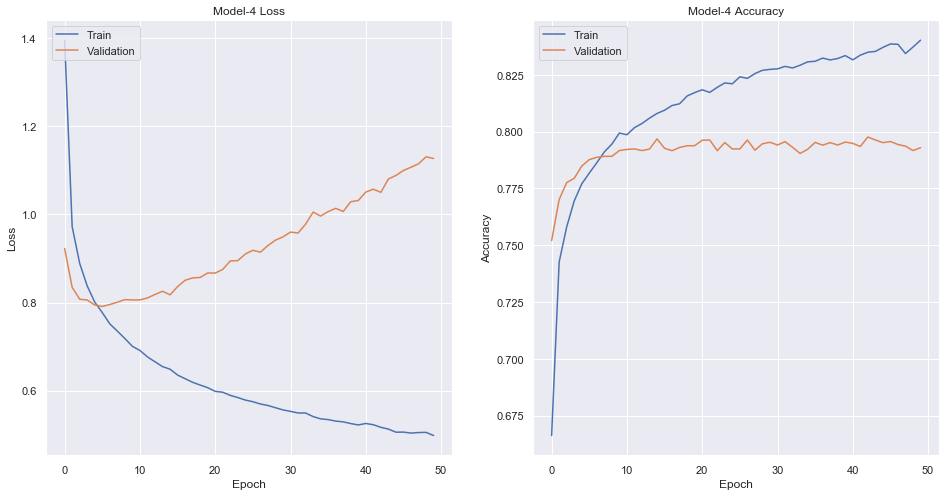

In [101]:
fig = plt.figure(figsize=(16,8))

# Plot training & validation loss values
plt.subplot(1,2,1)
plt.plot(history4.history['loss'])
plt.plot(history4.history['val_loss'])
plt.title('Model-4 Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation accuracy values
plt.subplot(1,2,2)
plt.plot(history4.history['acc'])
plt.plot(history4.history['val_acc'])
plt.title('Model-4 Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [102]:
layers = [X_train.shape[1], 100, 100, y_train.shape[1]]
model5 = build_model(layers, 0.5, 0, 0.0005)

history5 = model5.fit(X_train, y_train, epochs=80, batch_size=64, validation_data=valData, verbose=1, shuffle=True)

Train on 72325 samples, validate on 18082 samples
Epoch 1/80
72325/72325 [==============================] - 2s 32us/sample - loss: 1.8965 - acc: 0.5760 - val_loss: 1.2871 - val_acc: 0.6768
Epoch 2/80
72325/72325 [==============================] - 2s 29us/sample - loss: 1.3595 - acc: 0.6655 - val_loss: 1.0819 - val_acc: 0.7229
Epoch 3/80
72325/72325 [==============================] - 2s 27us/sample - loss: 1.2023 - acc: 0.6959 - val_loss: 0.9909 - val_acc: 0.7407
Epoch 4/80
72325/72325 [==============================] - 2s 25us/sample - loss: 1.1204 - acc: 0.7131 - val_loss: 0.9437 - val_acc: 0.7524
Epoch 5/80
72325/72325 [==============================] - 2s 28us/sample - loss: 1.0623 - acc: 0.7220 - val_loss: 0.9092 - val_acc: 0.7567
Epoch 6/80
72325/72325 [==============================] - 2s 25us/sample - loss: 1.0309 - acc: 0.7283 - val_loss: 0.8905 - val_acc: 0.7609
Epoch 7/80
72325/72325 [==============================] - 2s 25us/sample - loss: 1.0026 - acc: 0.7349 - val_loss: 0.

In [103]:
predicted5 = model5.predict(X_val)
predictedLabels5 = lb.inverse_transform(predicted5)
print ('Validation Acuracy: %.2f' %np.mean(predictedLabels5 == y_test_pos))

Validation Acuracy: 0.79


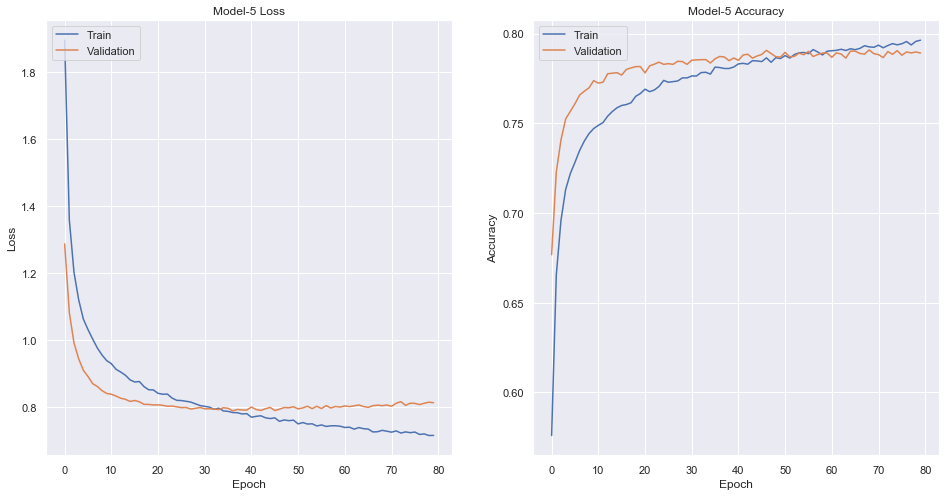

In [104]:
fig = plt.figure(figsize=(16,8))

# Plot training & validation loss values
plt.subplot(1,2,1)
plt.plot(history5.history['loss'])
plt.plot(history5.history['val_loss'])
plt.title('Model-5 Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation accuracy values
plt.subplot(1,2,2)
plt.plot(history5.history['acc'])
plt.plot(history5.history['val_acc'])
plt.title('Model-5 Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

As the epoch number is increased the network continues learning on the training data but it overfits the training data. Overfitting is the problem as can be seen. Overfitting was the problem with logistic regression as well. More data will definitely help. I did not look further into this, but playing with regularization parameters and different network architectures (# of hidden layers and units) can be the way trying to improve the performance. Also maybe the number of tf-idf features that are fed to the network can be decreased. Neural Network models studied for the label _position_ did not make a huge difference compared to the logistic regression so logistic regression model will be used for predictions. 

#### Training for the label _Subjects_

In [105]:
lb = LabelBinarizer()
lb.fit(dataWhole.subjects)
y_train = lb.transform(y_train_subjects)
print(y_train.shape)

TfIdf = TfidfVectorizer(analyzer='word', stop_words = 'english', lowercase=True, min_df=0.05, ngram_range=(1,2))

TfIdf.fit(X_train_subjects)
X_train = TfIdf.transform(X_train_subjects)

X_train = X_train.toarray()

scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)

print(X_train.shape)

X_val = scaler.transform(TfIdf.transform(X_test_subjects).toarray())
print(X_val.shape)

y_val = lb.transform(y_test_subjects)
print(y_val.shape)

valData = (X_val, y_val)

(72325, 63)
(72325, 775)
(18082, 775)
(18082, 63)


In [106]:
layers = [X_train.shape[1], 100, 100, 80, y_train.shape[1]]
model6 = build_model(layers, 0.4, 0, 0.0005)

history6 = model6.fit(X_train, y_train, epochs=70, batch_size=64, validation_data=valData, verbose=1, shuffle=True)

Train on 72325 samples, validate on 18082 samples
Epoch 1/70
72325/72325 [==============================] - 2s 32us/sample - loss: 2.5761 - acc: 0.4062 - val_loss: 1.9221 - val_acc: 0.5711
Epoch 2/70
72325/72325 [==============================] - 2s 27us/sample - loss: 1.9215 - acc: 0.5551 - val_loss: 1.5995 - val_acc: 0.6373
Epoch 3/70
72325/72325 [==============================] - 2s 27us/sample - loss: 1.6924 - acc: 0.6049 - val_loss: 1.4767 - val_acc: 0.6563
Epoch 4/70
72325/72325 [==============================] - 2s 27us/sample - loss: 1.5759 - acc: 0.6286 - val_loss: 1.3946 - val_acc: 0.6659
Epoch 5/70
72325/72325 [==============================] - 2s 27us/sample - loss: 1.4970 - acc: 0.6433 - val_loss: 1.3571 - val_acc: 0.6697
Epoch 6/70
72325/72325 [==============================] - 2s 27us/sample - loss: 1.4491 - acc: 0.6505 - val_loss: 1.3184 - val_acc: 0.6760
Epoch 7/70
72325/72325 [==============================] - 2s 27us/sample - loss: 1.4073 - acc: 0.6573 - val_loss: 1.

In [107]:
predicted6 = model6.predict(X_val)
predictedLabels6 = lb.inverse_transform(predicted6)
print('Validation Accuracy: %.2f' %np.mean(predictedLabels6 == y_test_subjects))

Validation Accuracy: 0.71


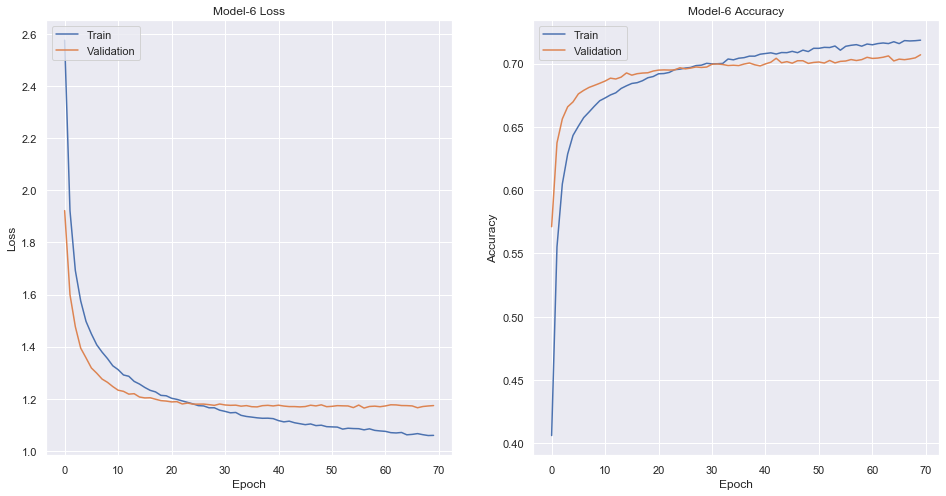

In [108]:
fig = plt.figure(figsize=(16,8))

# Plot training & validation loss values
plt.subplot(1,2,1)
plt.plot(history6.history['loss'])
plt.plot(history6.history['val_loss'])
plt.title('Model-6 Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation accuracy values
plt.subplot(1,2,2)
plt.plot(history6.history['acc'])
plt.plot(history6.history['val_acc'])
plt.title('Model-6 Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

The logistic regression resulted in an accuracy of 0.68 but the 4-layer neural network used here resulted in 0.71. This model will be used for predicting the _subjects_. 

In [109]:
model6.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_11 (Dense)             (None, 100)               77600     
_________________________________________________________________
dropout_6 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_12 (Dense)             (None, 100)               10100     
_________________________________________________________________
dropout_7 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_13 (Dense)             (None, 80)                8080      
_________________________________________________________________
dropout_8 (Dropout)          (None, 80)                0         
_________________________________________________________________
dense_14 (Dense)             (None, 63)               

Train on the whole dataset and save the model with the preprocessing steps. 

In [110]:
lb = LabelBinarizer()
lb.fit(dataWhole.subjects)
y_train = lb.transform(dataWhole.subjects)
print(y_train.shape)

TfIdf = TfidfVectorizer(analyzer='word', stop_words = 'english', lowercase=True, min_df=0.05, ngram_range=(1,2))

TfIdf.fit(dataWhole.features)
X_train = TfIdf.transform(dataWhole.features)

X_train = X_train.toarray()

scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)

print(X_train.shape)

(90407, 63)
(90407, 778)


In [111]:
layers = [X_train.shape[1], 100, 100, 80, y_train.shape[1]]
model = build_model(layers, 0.4, 0, 0.0005)

history = model.fit(X_train, y_train, epochs=70, batch_size=64, verbose=1, shuffle=True)

Train on 90407 samples
Epoch 1/70
90407/90407 [==============================] - 3s 38us/sample - loss: 2.4515 - acc: 0.4304
Epoch 2/70
90407/90407 [==============================] - 2s 23us/sample - loss: 1.8150 - acc: 0.5741
Epoch 3/70
90407/90407 [==============================] - 2s 23us/sample - loss: 1.6156 - acc: 0.6187
Epoch 4/70
90407/90407 [==============================] - 2s 23us/sample - loss: 1.5176 - acc: 0.6376
Epoch 5/70
90407/90407 [==============================] - 2s 23us/sample - loss: 1.4530 - acc: 0.6493
Epoch 6/70
90407/90407 [==============================] - 2s 23us/sample - loss: 1.4110 - acc: 0.6582
Epoch 7/70
90407/90407 [==============================] - 2s 23us/sample - loss: 1.3737 - acc: 0.6631
Epoch 8/70
90407/90407 [==============================] - 2s 23us/sample - loss: 1.3483 - acc: 0.6668
Epoch 9/70
90407/90407 [==============================] - 2s 23us/sample - loss: 1.3254 - acc: 0.6715
Epoch 10/70
90407/90407 [==============================] - 

In [112]:
model.save('models/NN_subjects.h5')

In [113]:
model = tf.keras.models.load_model('models/NN_subjects.h5')

In [114]:
accuracy_score(dataWhole.subjects, lb.inverse_transform(model.predict(X_train)))

0.7645536296968155

In [115]:
joblib.dump(TfIdf, 'models/TfIdf_Subjects.joblib') 

['TfIdf_Subjects.joblib']

In [116]:
joblib.dump(lb, 'models/LabelBinarizer_Subjects.joblib') 

['LabelBinarizer_Subjects.joblib']

In [117]:
joblib.dump(scaler, 'models/Scaler_Subjects.joblib') 

['Scaler_Subjects.joblib']

#### Training for the label _Workplaces_

In [120]:
lb = LabelBinarizer()
lb.fit(dataWhole.workplaces)
y_train = lb.transform(y_train_workplaces)
print(y_train.shape)

TfIdf = TfidfVectorizer(analyzer='word', stop_words = 'english', lowercase=True, min_df=0.05, ngram_range=(1,2))

TfIdf.fit(X_train_workplaces)
X_train = TfIdf.transform(X_train_workplaces)

X_train = X_train.toarray()

scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)

print(X_train.shape)

X_val = scaler.transform(TfIdf.transform(X_test_workplaces).toarray())
print(X_val.shape)

y_val = lb.transform(y_test_workplaces)
print(y_val.shape)

valData = (X_val, y_val)

(72325, 28)
(72325, 777)
(18082, 777)
(18082, 28)


In [121]:
layers = [X_train.shape[1], 100, 100, 80, y_train.shape[1]]
model7 = build_model(layers, 0.5, 0, 0.0005)

history7 = model7.fit(X_train, y_train, epochs=50, batch_size=64, validation_data=valData, verbose=1, shuffle=True)

Train on 72325 samples, validate on 18082 samples
Epoch 1/50
72325/72325 [==============================] - 2s 31us/sample - loss: 1.3399 - acc: 0.6222 - val_loss: 0.7382 - val_acc: 0.7931
Epoch 2/50
72325/72325 [==============================] - 2s 29us/sample - loss: 0.8376 - acc: 0.7611 - val_loss: 0.6015 - val_acc: 0.8301
Epoch 3/50
72325/72325 [==============================] - 2s 26us/sample - loss: 0.7129 - acc: 0.8003 - val_loss: 0.5476 - val_acc: 0.8440
Epoch 4/50
72325/72325 [==============================] - 2s 26us/sample - loss: 0.6488 - acc: 0.8175 - val_loss: 0.5170 - val_acc: 0.8516
Epoch 5/50
72325/72325 [==============================] - 2s 26us/sample - loss: 0.6103 - acc: 0.8266 - val_loss: 0.5010 - val_acc: 0.8531
Epoch 6/50
72325/72325 [==============================] - 2s 26us/sample - loss: 0.5809 - acc: 0.8348 - val_loss: 0.4852 - val_acc: 0.8590
Epoch 7/50
72325/72325 [==============================] - 2s 26us/sample - loss: 0.5598 - acc: 0.8418 - val_loss: 0.

In [122]:
predicted7 = model7.predict(X_val)
predictedLabels7 = lb.inverse_transform(predicted7)
print('Validation Accuracy: %.2f' %np.mean(predictedLabels7 == y_test_workplaces))

Validation Accuracy: 0.89


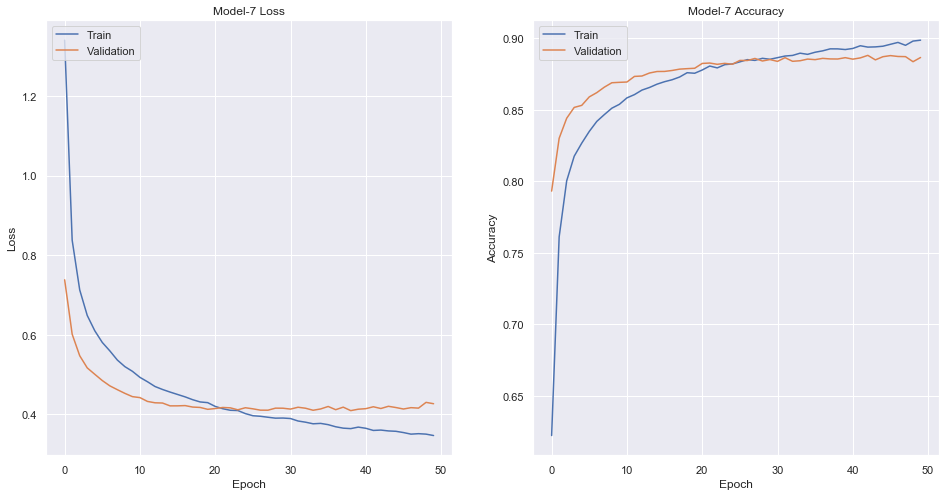

In [123]:
fig = plt.figure(figsize=(16,8))

# Plot training & validation loss values
plt.subplot(1,2,1)
plt.plot(history7.history['loss'])
plt.plot(history7.history['val_loss'])
plt.title('Model-7 Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation accuracy values
plt.subplot(1,2,2)
plt.plot(history7.history['acc'])
plt.plot(history7.history['val_acc'])
plt.title('Model-7 Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

The logistic regression resulted in an accuracy of 0.86 but the 4-layer neural network used here resulted in 0.89. This model will be used for predicting the _workplaces_. 

In [124]:
model7.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_19 (Dense)             (None, 100)               77800     
_________________________________________________________________
dropout_12 (Dropout)         (None, 100)               0         
_________________________________________________________________
dense_20 (Dense)             (None, 100)               10100     
_________________________________________________________________
dropout_13 (Dropout)         (None, 100)               0         
_________________________________________________________________
dense_21 (Dense)             (None, 80)                8080      
_________________________________________________________________
dropout_14 (Dropout)         (None, 80)                0         
_________________________________________________________________
dense_22 (Dense)             (None, 28)               

Train on the whole dataset and save the model with the preprocessing steps. 

In [125]:
lb = LabelBinarizer()
lb.fit(dataWhole.workplaces)
y_train = lb.transform(dataWhole.workplaces)
print(y_train.shape)

TfIdf = TfidfVectorizer(analyzer='word', stop_words = 'english', lowercase=True, min_df=0.05, ngram_range=(1,2))

TfIdf.fit(dataWhole.features)
X_train = TfIdf.transform(dataWhole.features)

X_train = X_train.toarray()

scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)

print(X_train.shape)

(90407, 28)
(90407, 778)


In [126]:
layers = [X_train.shape[1], 100, 100, 80, y_train.shape[1]]
modelWork = build_model(layers, 0.5, 0, 0.0005)

historyWork = modelWork.fit(X_train, y_train, epochs=50, batch_size=64, verbose=1, shuffle=True)

Train on 90407 samples
Epoch 1/50
90407/90407 [==============================] - 2s 26us/sample - loss: 1.2491 - acc: 0.6459
Epoch 2/50
90407/90407 [==============================] - 2s 24us/sample - loss: 0.7810 - acc: 0.7779
Epoch 3/50
90407/90407 [==============================] - 2s 27us/sample - loss: 0.6753 - acc: 0.8100
Epoch 4/50
90407/90407 [==============================] - 2s 24us/sample - loss: 0.6249 - acc: 0.8251
Epoch 5/50
90407/90407 [==============================] - 2s 26us/sample - loss: 0.5900 - acc: 0.8337
Epoch 6/50
90407/90407 [==============================] - 3s 29us/sample - loss: 0.5587 - acc: 0.8407
Epoch 7/50
90407/90407 [==============================] - 3s 29us/sample - loss: 0.5393 - acc: 0.8461
Epoch 8/50
90407/90407 [==============================] - 2s 25us/sample - loss: 0.5208 - acc: 0.8503
Epoch 9/50
90407/90407 [==============================] - 2s 23us/sample - loss: 0.5065 - acc: 0.8547
Epoch 10/50
90407/90407 [==============================] - 

In [127]:
accuracy_score(dataWhole.workplaces, lb.inverse_transform(modelWork.predict(X_train)))

0.936177508378776

In [128]:
modelWork.save('models/NN_workplaces.h5')

In [129]:
joblib.dump(TfIdf, 'models/TfIdf_Workplaces.joblib') 
joblib.dump(lb, 'models/LabelBinarizer_Workplaces.joblib') 
joblib.dump(scaler, 'models/Scaler_Workplaces.joblib') 

['Scaler_Workplaces.joblib']

## Predictions

The function for making predictions is given below. 

In [13]:
def makePredictions(instance, clfPos, clfSub, clfWork, TfIdf, SC, LbSub, LbWork):
    """
    Makes predictions for the position, subject and workplace tags for a given set of features.
    
    Arguments:
    instance --  a dictionary with 'title' and 'description' fields 
    clfPos   --  pipeline consisting of a trained tf-idf vectorizer, a trained scaler and a trained 
                 logistic regression model for predicting the tags for position
    clfSub   --  a trained neural network for predicting the tags for subject
    clfWork  --  a trained neural network for predicting the tags for workplace
    TfIdf    --  a trained tf-idf vectorizer to be used with clfSub and clfWork classifiers
    SC       --  a trained standard scaler to be used with clfSub and clfWork classifiers      
    LbSub    --  a trained label binarizer for the subject tags
    LbWork   --  a trained label binarizer for the subject workplaces
    
    Returns:
    predictions -- a dictionary containing the predicted tags for the position, subject and workplace
    """
    
    instance['description'] = re.sub('<.+?>', '', instance['description'])
    features = instance['title'] + " - " + instance['description']
    
    transformedF = TfIdf.transform([features]).toarray()
    transformedF = SC.transform(transformedF)
    
    positionTag = list(clfPos.predict([features]))
    if 'NA' in positionTag:
        positionTag = []
    
    subjectTag = clfSub.predict(transformedF)
    subjectTag = list(LbSub.inverse_transform(subjectTag))
    if 'NA' in subjectTag:
        subjectTag = []
    
    workplaceTag = clfWork.predict(transformedF)
    workplaceTag = list(LbWork.inverse_transform(workplaceTag))
    if 'NA' in workplaceTag:
        workplaceTag = []
    
    result = {'workplaces': workplaceTag, 'positions': positionTag, 'subjects': subjectTag}

    return result    

In [14]:
clfPos = joblib.load('models/LR_Model_Positions.joblib') 
clfSub = tf.keras.models.load_model('models/NN_subjects.h5')
clfWork = tf.keras.models.load_model('models/NN_workplaces.h5')
TfIdf = joblib.load('models/TfIdf_Workplaces.joblib') 
SC = joblib.load('models/Scaler_Workplaces.joblib') 
LbSub = joblib.load('models/LabelBinarizer_Subjects.joblib') 
LbWork = joblib.load('models/LabelBinarizer_Workplaces.joblib') 

In [11]:
testData = []

with open("datasets/test.json") as infile:
    for line in infile:
        testData.append(json.loads(line))

In [15]:
makePredictions(testData[0][0], clfPos, clfSub, clfWork, TfIdf, SC, LbSub, LbWork)

{'workplaces': ['further education'],
 'positions': ['deputy headteacher'],
 'subjects': []}

In [10]:
dataTest = pd.read_json("datasets/test.json")
dataTest.head()

,title,description,positions,subjects,workplaces
0,Head of Curriculum,<p>Ambitious College&nbsp;is a good College (O...,"[{'id': '10809', 'description': 'Head of Depar...","[{'id': '10552', 'description': 'Special Needs...","[{'id': '110511', 'description': 'Special educ..."
1,ICT Technician,<P>An exciting opportunity has arisen for a kn...,"[{'id': '70055', 'description': 'Technician', ...","[{'id': '10535', 'description': 'Information T...","[{'id': '10510', 'description': 'Secondary', '..."
2,Deputy Leader of Mathematics,<p>Deputy Leader of Mathematics&nbsp;</p>\n<p>...,"[{'id': '70024', 'description': 'Deputy/Assist...","[{'id': '10538', 'description': 'Mathematics',...","[{'id': '110510', 'description': 'Secondary', ..."
3,"Science Technician, part time (29 hours per we...",<p>We seek a &nbsp;well-qualified and enthusia...,"[{'id': '70055', 'description': 'Technician', ...","[{'id': '10549', 'description': 'Science', 'ca...","[{'id': '110502', 'description': 'Independent ..."
4,Computing/ICT Teacher,<p>Teacher of Computing/ICT &nbsp;&nbsp;&nbsp;...,"[{'id': '10804', 'description': 'Teacher', 'ca...","[{'id': '10535', 'description': 'Information T...","[{'id': '110510', 'description': 'Secondary', ..."


In [12]:
len(dataTest)

22602

In [13]:
dataTest.isnull().any()

title          False
description    False
positions      False
subjects       False
workplaces     False
dtype: bool

In [14]:
featureTest1 = list(dataTest.title)
featureTest1

['Head of Curriculum',
 'ICT Technician',
 'Deputy Leader of Mathematics',
 'Science Technician, part time (29 hours per week), term time, permanent',
 'Computing/ICT Teacher',
 'Leader of Teaching and Learning with English Specialism',
 'Teacher of Maths with Leadership opportunities',
 'Co-ordinator of Science',
 'Teaching Assistant',
 'Teacher of English - Bilston',
 'Midday Assistant',
 'Learning Support Assistant SEN',
 "SEN Teaching Assistant's - Nottinghamshire",
 'Year 2 Teacher',
 'Head of Science',
 'Nursery Assistant',
 'Teacher of Science',
 'Teacher of Technical',
 'Head of Senior School',
 'Head of Sixth Form',
 'Key Stage 1 Teacher',
 'Teacher of Business, ICT and Computing',
 'Primary Key Stage 2 Teacher',
 'Registrar - Prep School',
 'Academy Support Administrator',
 'English Teacher',
 'Teacher of Drama',
 'Teacher of Music/Performing Arts',
 'Teacher of English',
 'Progress Officer',
 'Office Assistant Apprentice - (Intermediate, Level 2) - Fixed Term',
 'Assistant B

In [15]:
featureTest2 = []

for s in dataTest.description:
    featureTest2.append(re.sub('<.+?>', '', s))

In [16]:
# Combine the features (titles and descriptions)
featuresTest = []

for a,b in zip(featureTest1, featureTest2):
    featuresTest.append(a + " - " + b)

In [17]:
subjectsTest = [x[0]["description"].strip().lower() if x != [] else 'NA' for x in dataTest.subjects]

In [18]:
positionsTest = [x[0]["description"].strip().lower() if x != [] else 'NA' for x in dataTest.positions]
workplacesTest = [x[0]["description"].strip().lower() if x != [] else 'NA' for x in dataTest.workplaces]

In [19]:
d = {'features': [], 'positions': [], 'subjects': [], 'workplaces': []}
dataWholeTest = pd.DataFrame(d)
dataWholeTest.features = featuresTest
dataWholeTest.positions = positionsTest
dataWholeTest.subjects = subjectsTest
dataWholeTest.workplaces = workplacesTest
dataWholeTest.head(10)

,features,positions,subjects,workplaces
0,Head of Curriculum - Ambitious College&nbsp;is...,head of department,special needs,special education
1,ICT Technician - An exciting opportunity has a...,technician,information technology,secondary
2,Deputy Leader of Mathematics - Deputy Leader o...,deputy/assistant of department/faculty,mathematics,secondary
3,"Science Technician, part time (29 hours per we...",technician,science,independent senior
4,Computing/ICT Teacher - Teacher of Computing/I...,teacher,information technology,secondary
5,Leader of Teaching and Learning with English S...,leader/co-ordinator,english,secondary
6,Teacher of Maths with Leadership opportunities...,teacher,mathematics,secondary
7,Co-ordinator of Science - Co-ordinator of Scie...,director of faculty/department,science,secondary
8,Teaching Assistant - Smart Teachers is recruit...,teaching assistant,child development,primary
9,Teacher of English - Bilston - ABC Teachers ar...,teacher,english,secondary


In [20]:
posTestPred = clfPos.predict(dataWholeTest.features)
posTestPred

array(['deputy headteacher', 'technician', 'teacher', ..., 'teacher',
       'teacher', 'headteacher'], dtype=object)

In [21]:
print('Accuracy for Positions using the test data is %.2f' %accuracy_score(dataWholeTest.positions, posTestPred))

Accuracy for Positions using the test data is 0.78


In [22]:
transformedF = TfIdf.transform(dataWholeTest.features).toarray()
transformedF = SC.transform(transformedF)

subTestPred = clfSub.predict(transformedF)
subTestPred = LbSub.inverse_transform(subTestPred)
workTestPred = clfWork.predict(transformedF)
workTestPred = LbWork.inverse_transform(workTestPred)

In [23]:
print('Accuracy for Subjects using the test data is %.2f' %accuracy_score(dataWholeTest.subjects, subTestPred))

Accuracy for Subjects using the test data is 0.71


In [24]:
print('Accuracy for Workplaces using the test data is %.2f' %accuracy_score(dataWholeTest.workplaces, workTestPred))

Accuracy for Workplaces using the test data is 0.89


These accuracies can be reported as the generalization errors for each label. 

In [25]:
predictionsTest = []

for index in range(len(dataWholeTest)):
    
    result = {}
    
    if workTestPred[index] == 'NA':
        result['workplaces'] = []
    else:
        result['workplaces'] = [workTestPred[index]] 
        
    if posTestPred[index] == 'NA':
        result['positions'] = []
    else:
        result['positions'] = [posTestPred[index]]
        
    if subTestPred[index] == 'NA':
        result['subjects'] = []
    else:
        result['subjects'] = [subTestPred[index]]
        
    predictionsTest.append(result)

predictionsTest

[{'workplaces': ['further education'],
  'positions': ['deputy headteacher'],
  'subjects': []},
 {'workplaces': ['secondary'], 'positions': ['technician'], 'subjects': []},
 {'workplaces': ['secondary'],
  'positions': ['teacher'],
  'subjects': ['mathematics']},
 {'workplaces': ['independent senior'],
  'positions': ['technician'],
  'subjects': ['science']},
 {'workplaces': ['secondary'],
  'positions': ['teacher'],
  'subjects': ['information technology']},
 {'workplaces': ['secondary'],
  'positions': ['head of department'],
  'subjects': ['english']},
 {'workplaces': ['secondary'],
  'positions': ['teacher'],
  'subjects': ['mathematics']},
 {'workplaces': ['secondary'],
  'positions': ['head of department'],
  'subjects': ['science']},
 {'workplaces': ['primary'],
  'positions': ['teaching assistant'],
  'subjects': []},
 {'workplaces': ['secondary'],
  'positions': ['teacher'],
  'subjects': ['english']},
 {'workplaces': ['primary'],
  'positions': ['other support positions'],


In [26]:
makePredictions(testData[0][0], clfPos, clfSub, clfWork, TfIdf, SC, LbSub, LbWork)

{'workplaces': ['further education'],
 'positions': ['deputy headteacher'],
 'subjects': []}

In [27]:
makePredictions(testData[0][1], clfPos, clfSub, clfWork, TfIdf, SC, LbSub, LbWork)

{'workplaces': ['secondary'], 'positions': ['technician'], 'subjects': []}

In [28]:
makePredictions(testData[0][2], clfPos, clfSub, clfWork, TfIdf, SC, LbSub, LbWork)

{'workplaces': ['secondary'],
 'positions': ['teacher'],
 'subjects': ['mathematics']}

The created function _makePredictions_ gives the same results as shown above. 

In [29]:
with open('predictions.json', 'w') as fout:
    json.dump(predictionsTest, fout)

## Conclusion and Future Work

Mostly the explanations are given during the model exploration process. Below is a brief summary of what was done and how the results can tried to be improved.
* I started with a simple linear model, which is logistic regression. I wanted to implement something quickly and then try to examine the problems with the model. When I plotted the learning curves, I saw that overfitting is the main problem and gathering more data will definitely be helpful, especially for the labels which are infrequent in the dataset. Logistic regression was implemented without a scaler as well (not shown). Using scalers for logisitc regression models resulted in the same accuracies measured on the validation set as the models without scalers. 
* I compared models based on accuracy on the validation data. Validation data is seperated using stratified sampling so that roughly the same proportion of labels will go into the training and validation sets. Cross-validation can be another technique for model selection and hyperparameter tuning. To predict the tags for position, a logistic regression model is trained. For predicting the tags for subjects and workplaces, neural networks with 4-layers are trained. 
* Gathering more data would be a good way of trying to improve the models since the main problem is overfitting (variance). Playing with regularization parameters, trying to decrease the number of tf-idf features can be other strategies for improving the accuracy on the validtation set. L1 norm can be tried instead of L2 or a combination of both (elastic net). For the NN (Neural Network) models, different network architectures can be tried as well as playing with the learning rate, the # of epochs and mini-batch size. The errors made by the chosen models can be studied to see if there are any patterns in the errors made. This can give clues for finding ways for improving the results. An SVM (Support Vector Machine) with linear kernel can be tried to see if the accuracy would be improved. Multi-task learning is another possibility since there are 3 labels and these labels can be learnt at the same time. Also RNN (Recurrent Neural Networks) like LSTM (Long Short-Term Memory) networks can be trained. These networks can give good results for sequential data like text data.

As a future work, multi-task learning and LSTMs will be applied to see if improved accuracies can be achieved. 